# Data Cleaning and Prep

In [295]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' #This line is necessary on macbook s.t. models compile
import os

plt.style.use('seaborn-colorblind')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [434]:
# Import the data, here I had to import 3 different csvs due to the available download
df1 = pd.read_csv('Good Data/S&P 500 Historical Data (1).csv')
df2 = pd.read_csv('Good Data/S&P 500 Historical Data (2).csv')
df3 = pd.read_csv('Good Data/S&P 500 Historical Data (3).csv')

In [435]:
df1.tail()

Date   Price    Open    High     Low  Vol. Change %
4994  01/01/1980  107.90  107.90  107.90  107.90   NaN    0.00%
4995  31/12/1979  107.90  107.90  108.50  107.30   NaN    0.09%
4996  28/12/1979  107.80  107.80  108.60  107.20   NaN   -0.19%
4997  27/12/1979  108.00  108.00  108.50  107.10   NaN    0.19%
4998  26/12/1979  107.80  107.80  108.40  107.10   NaN    0.09%

In [436]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(4999, 7)
(5000, 7)
(867, 7)


In [437]:
# Merge all tables
df = pd.concat([df3, df2, df1], axis = 0, join = 'outer')

In [438]:
print(df.shape)

(10866, 7)


In [439]:
# Checking the format of the table
df.head(10)

Date     Price      Open      High       Low  Vol. Change %
0  23/01/2023  4,013.35  3,980.60  4,039.63  3,969.70   NaN    1.03%
1  20/01/2023  3,972.61  3,909.04  3,972.96  3,897.86   NaN    1.89%
2  19/01/2023  3,898.85  3,911.84  3,922.94  3,885.54   NaN   -0.76%
3  18/01/2023  3,928.86  4,002.25  4,014.16  3,926.59   NaN   -1.56%
4  17/01/2023  3,990.97  3,999.28  4,015.39  3,984.57   NaN   -0.20%
5  13/01/2023  3,999.09  3,960.60  4,003.95  3,947.67   NaN    0.40%
6  12/01/2023  3,983.17  3,977.57  3,997.76  3,937.56   NaN    0.34%
7  11/01/2023  3,969.61  3,932.35  3,970.07  3,928.54   NaN    1.28%
8  10/01/2023  3,919.25  3,888.57  3,919.83  3,877.29   NaN    0.70%
9  09/01/2023  3,892.09  3,910.82  3,950.57  3,890.42   NaN   -0.08%

In [440]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y', errors = 'coerce')

# Sort by values, date ascending
df = df.sort_values(by = 'Date')

In [441]:
# Drop bad data
df = df.drop(df[df["Price"]==0].index)
df = df.drop('High', axis = 1)
df = df.drop('Low', axis = 1)
df = df.drop('Vol.', axis = 1)
df = df.drop('Change %', axis = 1)

# Set index to be date ascending
df = df.set_index('Date')

# Rename columns
df = df.rename(columns={'Price': 'close'})
df = df.rename(columns={'Open': 'open'})

In [442]:
df.head()

close    open
Date                      
1979-12-26  107.80  107.80
1979-12-27  108.00  108.00
1979-12-28  107.80  107.80
1979-12-31  107.90  107.90
1980-01-01  107.90  107.90

In [443]:
# Shift Open column up by one, so that you can also use the open price to predict the close price of that day
df['open'] = df['open'].shift(1)

In [444]:
# Count NaN values in each column
nan_counts = df.isna().sum()

for col, count in nan_counts.items():
    print(f'{col}: {count}')

close: 0
open: 1


In [445]:
df = df.dropna()

# Remove commas as this causes error when convert to float
df['close'] = df['close'].str.replace(',','')
df['open'] = df['open'].str.replace(',','')

# Convert these columns to float so that they can be parsed
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)

In [446]:
# Calculate the percent change and the daily returns
df['gradient'] = (df['close'].shift(1) - df['close']) / df['close'].shift(1)
df['returns'] = df['gradient'] * 100

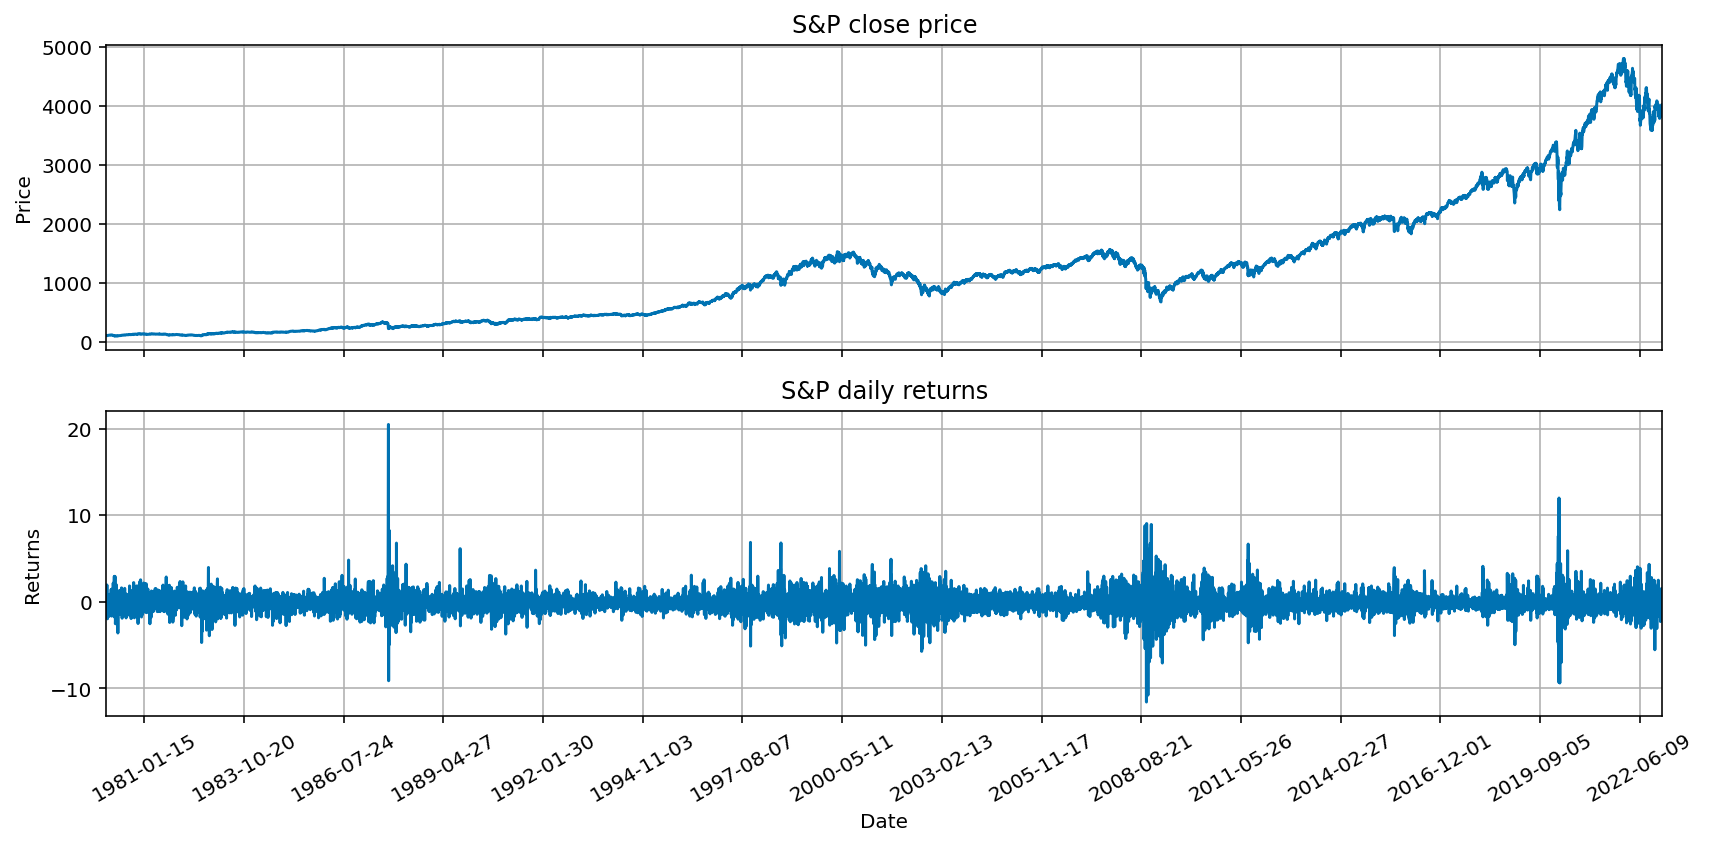

In [447]:
# Plot our results to ensure there are no outliers
df = df.dropna()

fig, ax = plt.subplots(2,1, sharex=True, figsize=(12,6))

ax[0].plot(df['close'], label = 'Ticket')
ax[0].set(title = 'S&P close price', ylabel = 'Price')
ax[0].grid(True)

ax[1].plot(df['returns'], label = 'Daily Returns')
ax[1].set(title = 'S&P daily returns', ylabel = 'Returns', xlabel = 'Date')
ax[1].grid(True)

plt.xlim(left = df.index[0])
plt.xlim(right = df.index[-1])
plt.xticks(rotation = 30)
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.tight_layout();

In [448]:
# Include SMA 30, 50, 70 and EMA 30, 50, 70
df['SMA50'] = df['close'].rolling(50).mean()
df['SMA70'] = df['close'].rolling(70).mean()
df['SMA30'] = df['close'].rolling(30).mean()

df['EMA30'] = df['close'].ewm(span = 30, adjust = False). mean()
df['EMA50'] = df['close'].ewm(span = 50, adjust = False). mean()
df['EMA70'] = df['close'].ewm(span = 70, adjust = False). mean()

In [449]:
# We import these technical indicators to help us predict
from talib import RSI, BBANDS

In [450]:
#Using RSI and BBbands as technical indicators
df['rsi'] = RSI(df['close'])

high, mid, low = BBANDS(df['close'], timeperiod = 50)

df = df.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index = df.index))

In [451]:
df = df.dropna()

In [452]:
df.shape

(10799, 13)

In [453]:
df.head()

close   open  gradient   returns    SMA50       SMA70       SMA30  \
Date                                                                            
1980-04-03  102.2  102.7  0.004869  0.486855  109.992  109.862857  106.210000   
1980-04-07  100.2  102.2  0.019569  1.956947  109.724  109.754286  105.716667   
1980-04-08  101.2  100.2 -0.009980 -0.998004  109.452  109.658571  105.313333   
1980-04-09  103.1  101.2 -0.018775 -1.877470  109.232  109.590000  104.950000   
1980-04-10  104.1  103.1 -0.009699 -0.969932  109.010  109.565714  104.673333   

                 EMA30       EMA50       EMA70        rsi     bb_high  \
Date                                                                    
1980-04-03  105.215753  107.100179  107.922519  40.454823  122.332168   
1980-04-07  104.892156  106.829584  107.704983  35.218218  122.318511   
1980-04-08  104.653952  106.608816  107.521744  39.439312  122.182954   
1980-04-09  104.553697  106.471215  107.397188  46.563689  122.014140   
1980-04-10  104.524426  106.378226  107.304309  49.904023  121.755336   

               bb_low  
Date                   
1980-04-03  97.651832  
1980-04-07  97.129489  
1980-04-08  96.721046  
1980-04-09  96.449860  
1980-04-10  96.264664

In [454]:
split_ratio = 0.8
10799 * split_ratio

8639.2

In [455]:
# Split data into training and test sets, we will do the same but with validation later
training_data = df[:8639]
test_data = df[8639:]

In [456]:
# Create standard scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(training_data)

# Standardize the training and test data
training_scaled = scaler.fit_transform(training_data)
testing_scaled = scaler.fit_transform(test_data)

<function matplotlib.pyplot.show(close=None, block=None)>

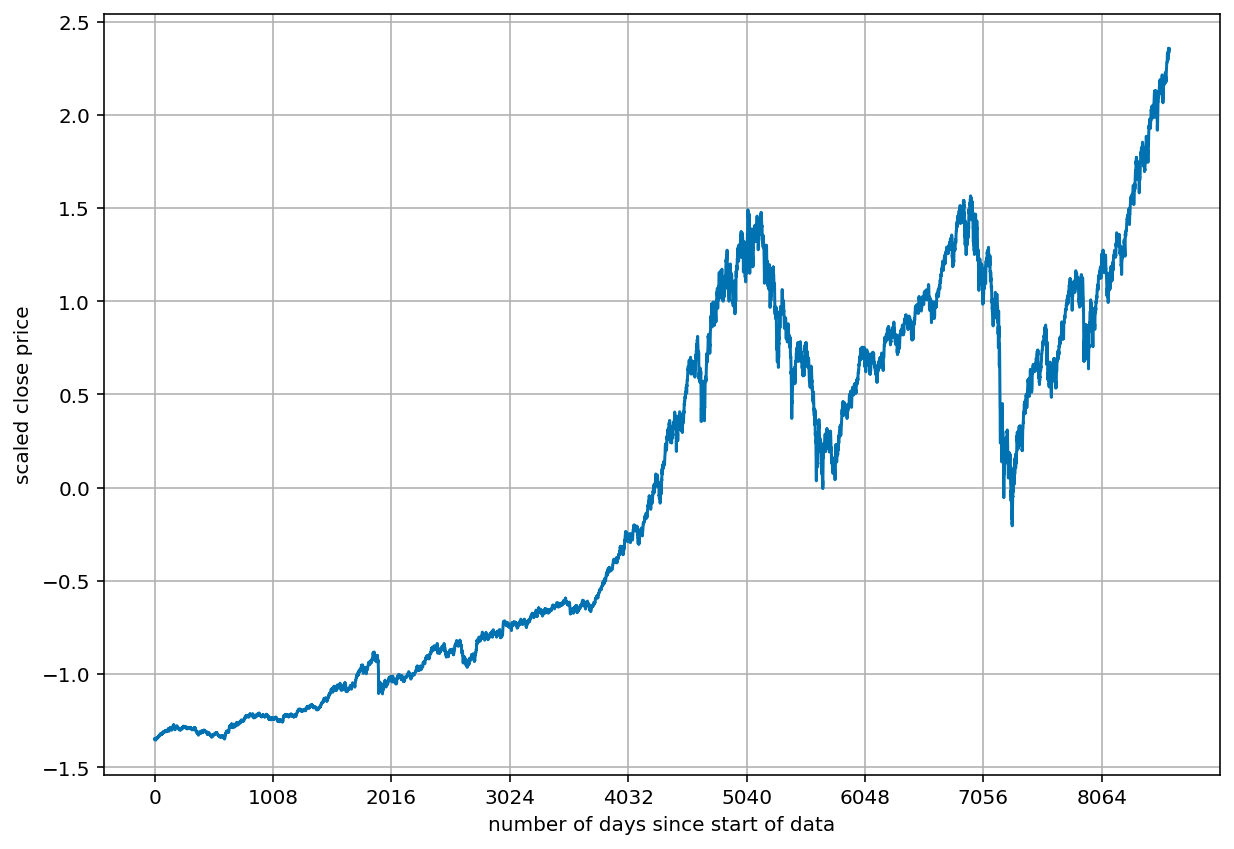

In [457]:
# Plot standard scaled close prices
plt.subplots(figsize = (10,7))
plt.plot(training_scaled[:,0])
plt.xlabel('number of days since start of data')
plt.ylabel('scaled close price')
plt.gca().xaxis.set_major_locator(MultipleLocator(1008))
plt.grid(True)
plt.show

# Prediction Modelling

In [458]:
# Create the training data
X_train, y_train = [], []

time_step = 50

length_train = 8639 # length data * 0.8

# This step is necessary to pass into a RNN
for i in range(time_step, length_train):
    X_train.append(training_scaled[i - time_step : i, :])
    y_train.append(training_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [459]:
# Creating the test data
X_test, y_test = [], []

length_train = test_data.shape[0]

for i in range(time_step, length_train):
    X_test.append(testing_scaled[i - time_step : i, :])
    y_test.append(testing_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [460]:
print(X_train.shape)
print(y_train.shape)

(8589, 50, 13)
(8589,)


In [461]:
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (-1,1))

In [324]:
# Define the model
model = Sequential([
    SimpleRNN(100, return_sequences = True),
    SimpleRNN(100, return_sequences = True),
    SimpleRNN(100),
    Dense(1)
])

# We are using three layers of simpleRNN, and a single dense output layer, as we only want to output the close price 

In [329]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50, 100)           11400     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50, 100)           20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
_________________________________________________________________


In [326]:
# Define some model parameters
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [327]:
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

In [328]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
269/269 [==============================] - 7s 16ms/step - loss: 0.0246 - accuracy: 0.0000e+00
Epoch 2/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0025 - accuracy: 0.0000e+00
Epoch 3/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0016 - accuracy: 0.0000e+00
Epoch 4/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 5/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 6/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 7/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 8/100
269/269 [==============================] - 4s 17ms/step - loss: 0.0010 - accuracy: 0.0000e+00
Epoch 9/100
269/269 [==============================] - 4s 16ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 10/100
269/269 [========================

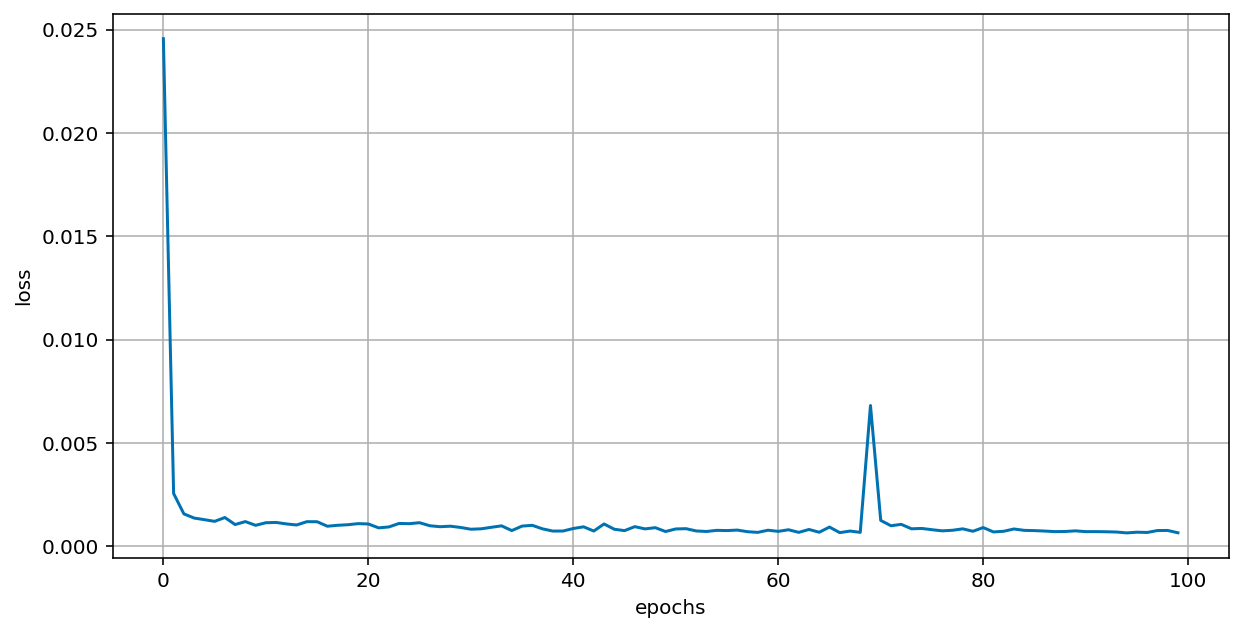

In [330]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [331]:
testing_scaled.shape

(2160, 13)

In [332]:
model.evaluate(X_test, y_test)

66/66 [==============================] - 1s 6ms/step - loss: 0.0047 - accuracy: 0.0000e+00


[0.004667876288294792, 0.0]

In [462]:
y_pred = model.predict(X_train)

# Unscale the predicted values
# create empty table with 13 fields (same number of columns)
y_pred_dataset_like = np.zeros(shape=(len(y_pred), 13) )

# put the predicted values in the right field
y_pred_dataset_like[:,0] = y_pred[:,0]
# inverse transform and then select the right field
y_pred = scaler.inverse_transform(y_pred_dataset_like)[:,0]

y_pred = np.reshape(y_pred, (y_pred.shape[0],1))

print(y_pred.shape)

269/269 [==============================] - 2s 8ms/step
(8589, 1)


In [463]:
# Unscaled the training set values
# create empty table with 13 fields
y_train_dataset_like = np.zeros(shape=(len(y_train), 13) )

# put the predicted values in the right field
y_train_dataset_like[:,0] = y_train[:,0]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(y_train_dataset_like)[:,0]

y_train = np.reshape(y_train, (y_train.shape[0],1))

print(y_train.shape)

(8589, 1)


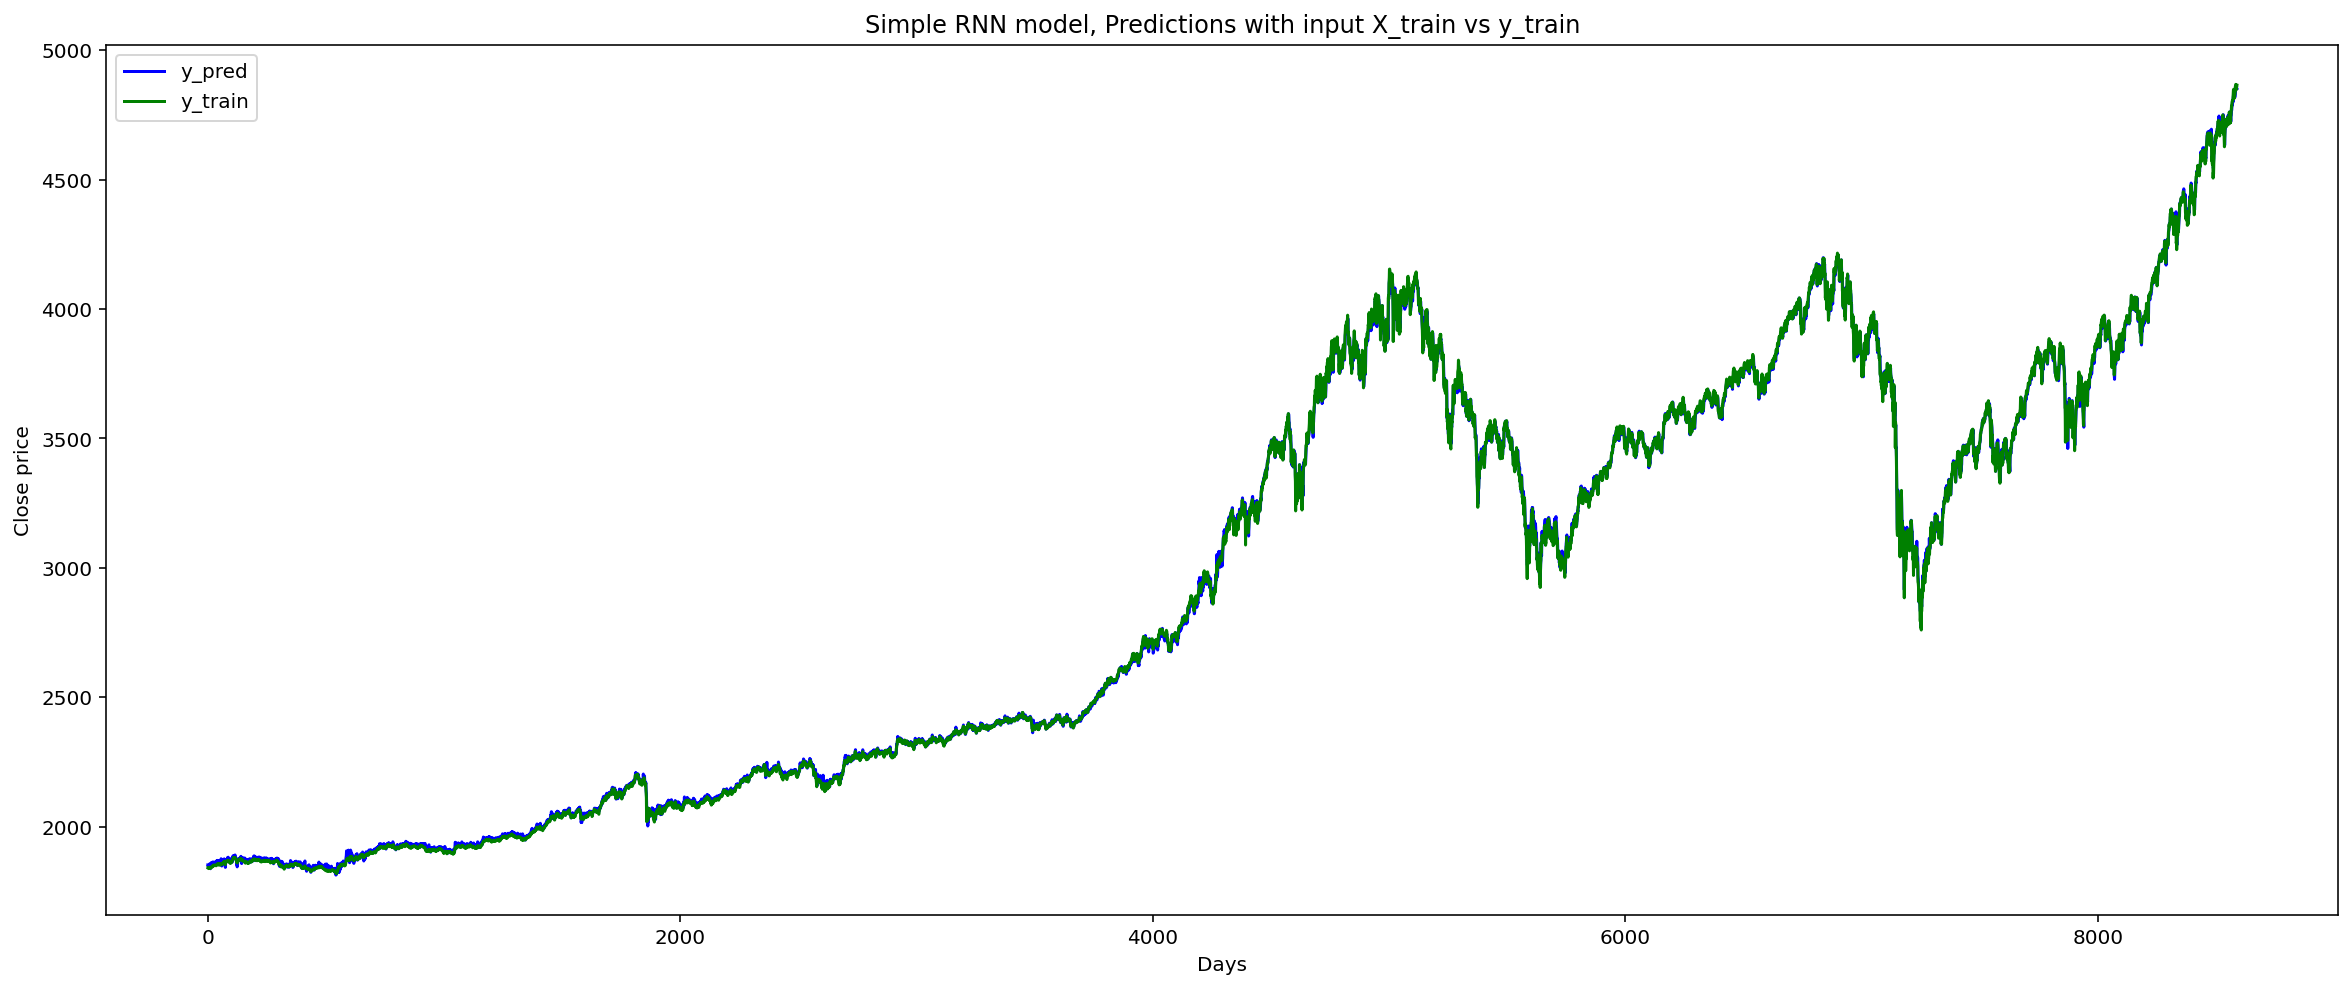

In [464]:
plt.figure(figsize = (20,8))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [465]:
# Make a prediction on the test set
y_pred_on_test = model.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

66/66 [==============================] - 1s 8ms/step


In [466]:
# Unscale these values
# create empty table with 13 fields
y_test_pred_dataset_like = np.zeros(shape=(len(y_pred_on_test), 13))

# put the predicted values in the right field
y_test_pred_dataset_like[:,0] = y_pred_on_test[:,0]
# inverse transform and then select the right field
y_pred_on_test = scaler.inverse_transform(y_test_pred_dataset_like)[:,0]

y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

print(y_pred_on_test.shape)

(2110, 1)


In [467]:
# create empty table with 13 fields
y_test_dataset_like = np.zeros(shape=(len(y_test), 13))

# put the predicted values in the right field
y_test_dataset_like[:,0] = y_test[:,0]
# inverse transform and then select the right field
y_test = scaler.inverse_transform(y_test_dataset_like)[:,0]

y_test = np.reshape(y_test, (-1,1))

print(y_test.shape)

(2110, 1)


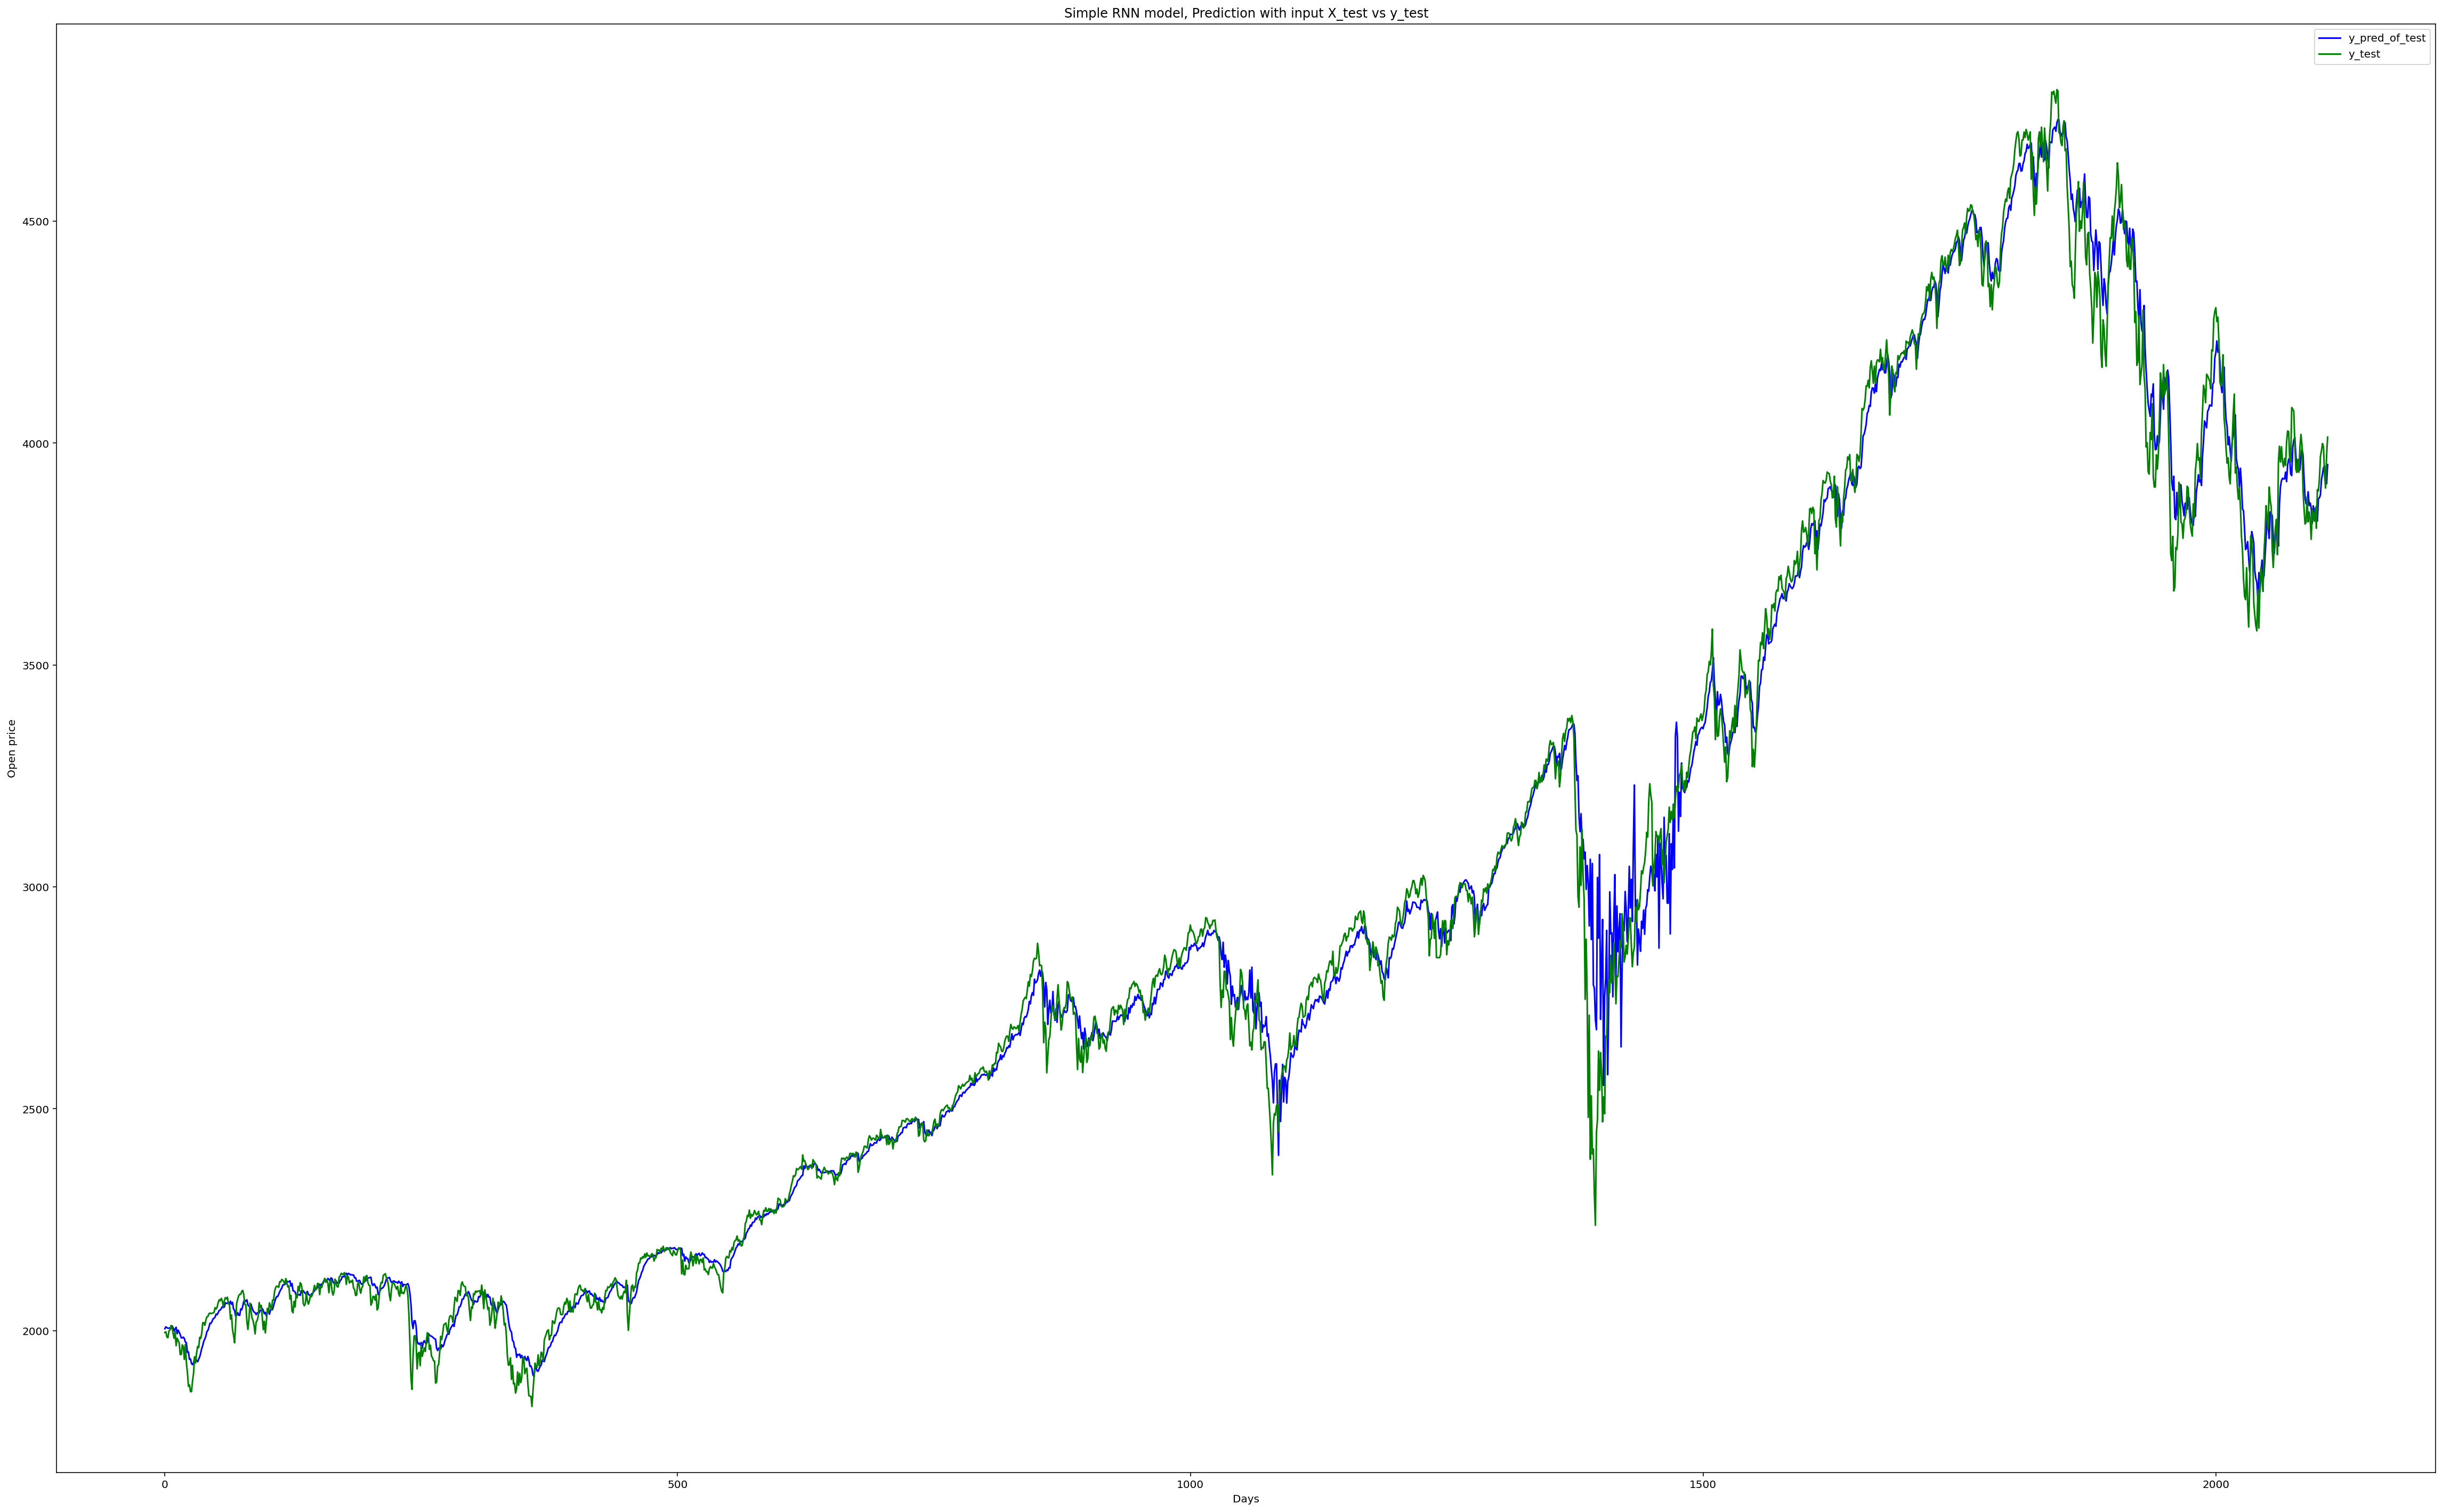

In [468]:
plt.figure(figsize = (40,25))
plt.plot(y_pred_on_test, label = "y_pred_of_test", c = "blue")
plt.plot(y_test, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [469]:
y_test.shape[0]/5

422.0

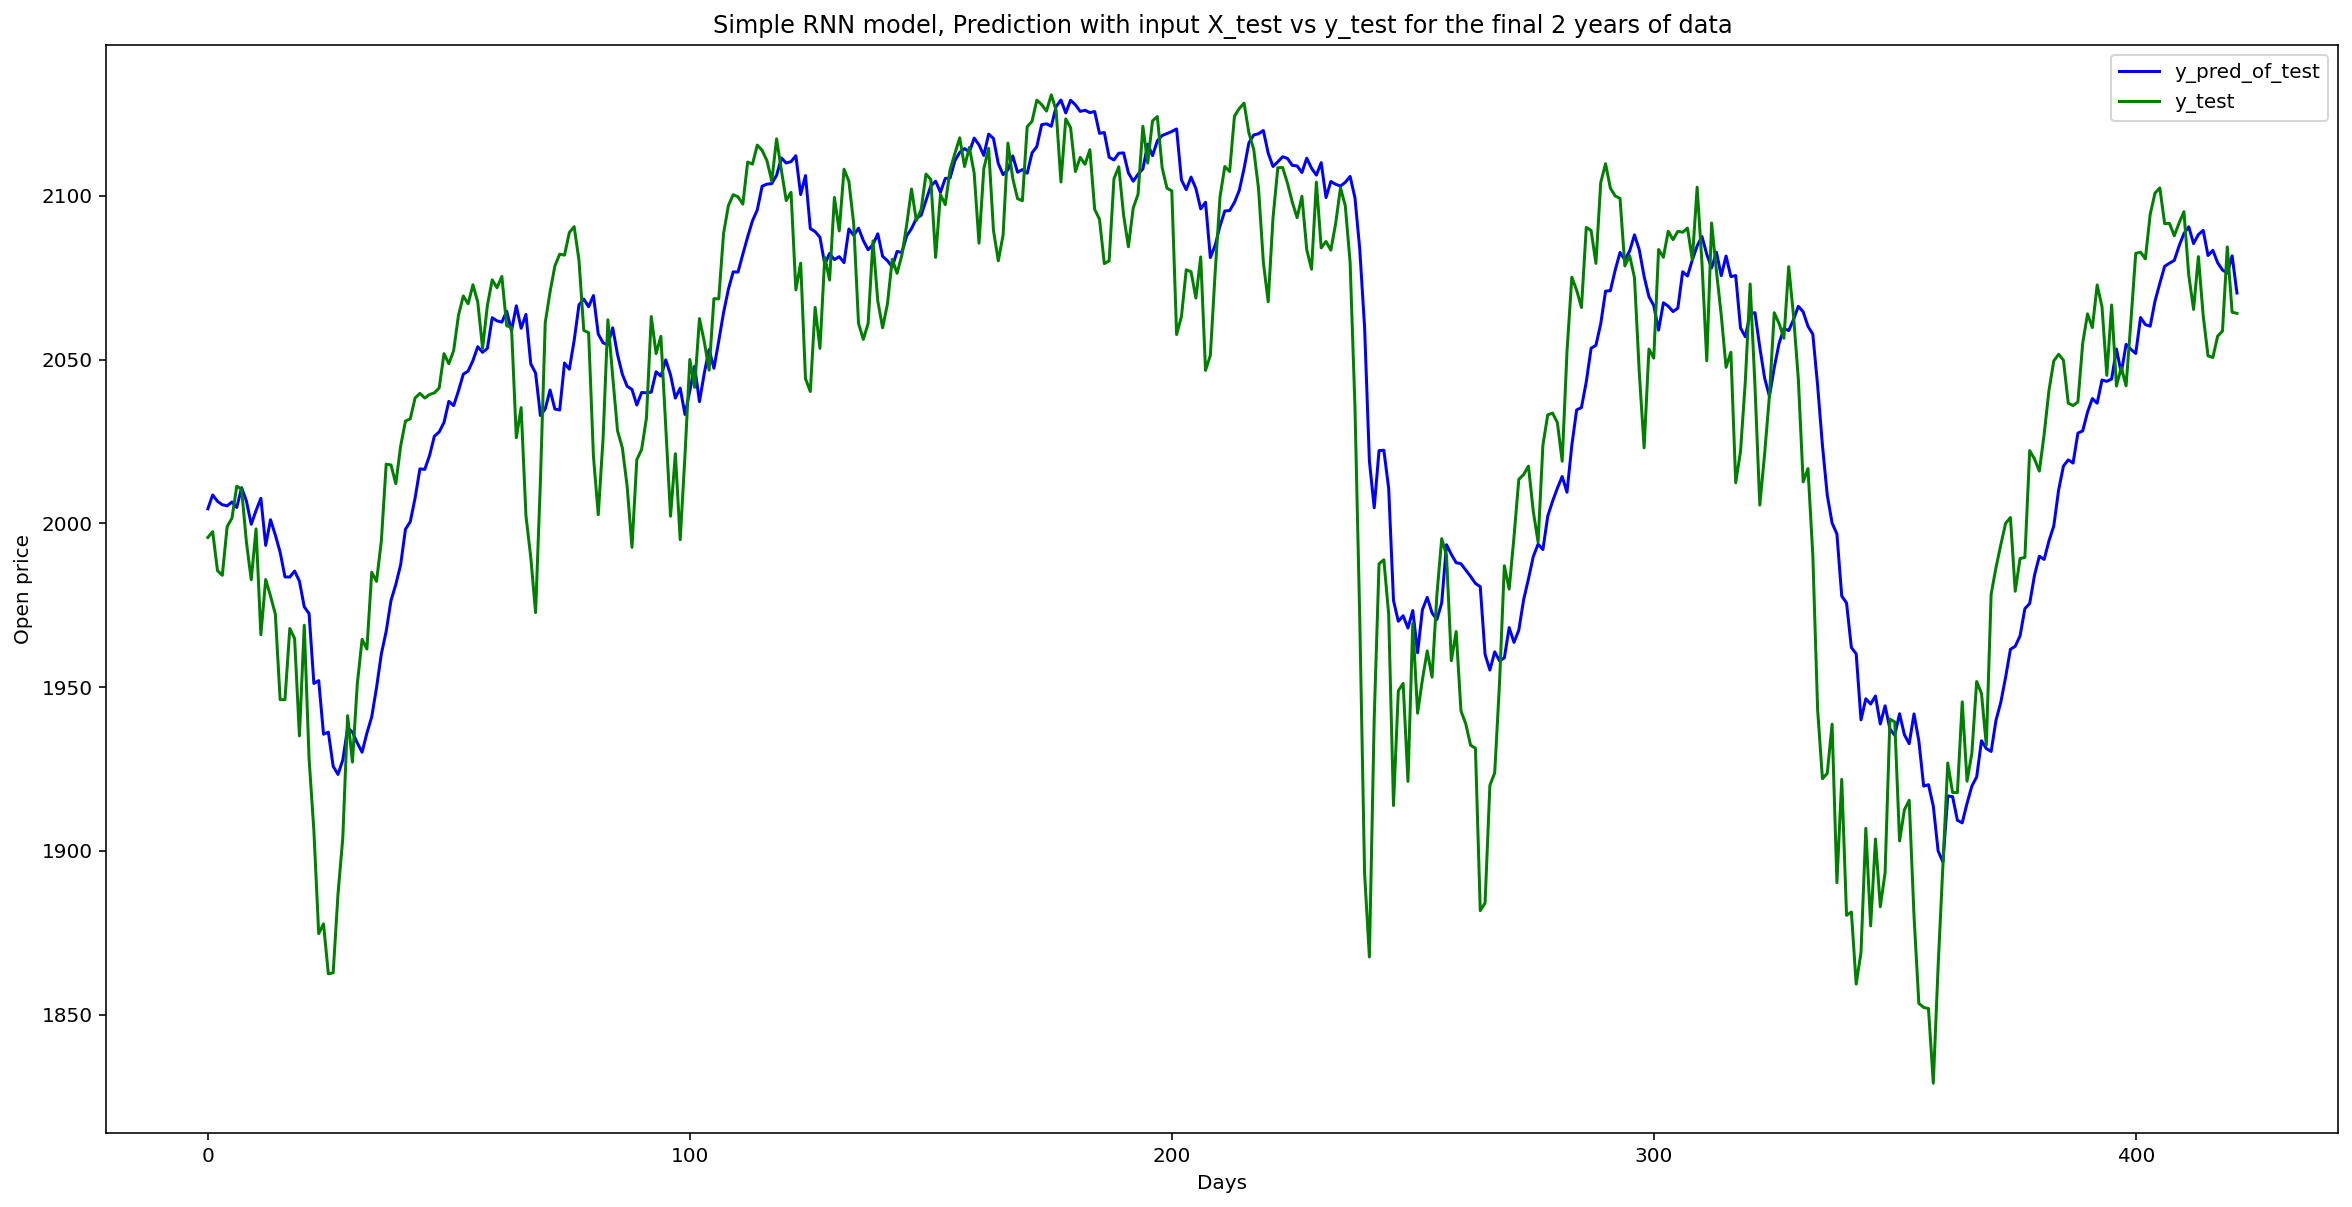

In [470]:
plt.figure(figsize = (20,10))
plt.plot(y_pred_on_test[:422], label = "y_pred_of_test", c = "blue")
plt.plot(y_test[:422], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test for the final 2 years of data")
plt.legend()
plt.show()

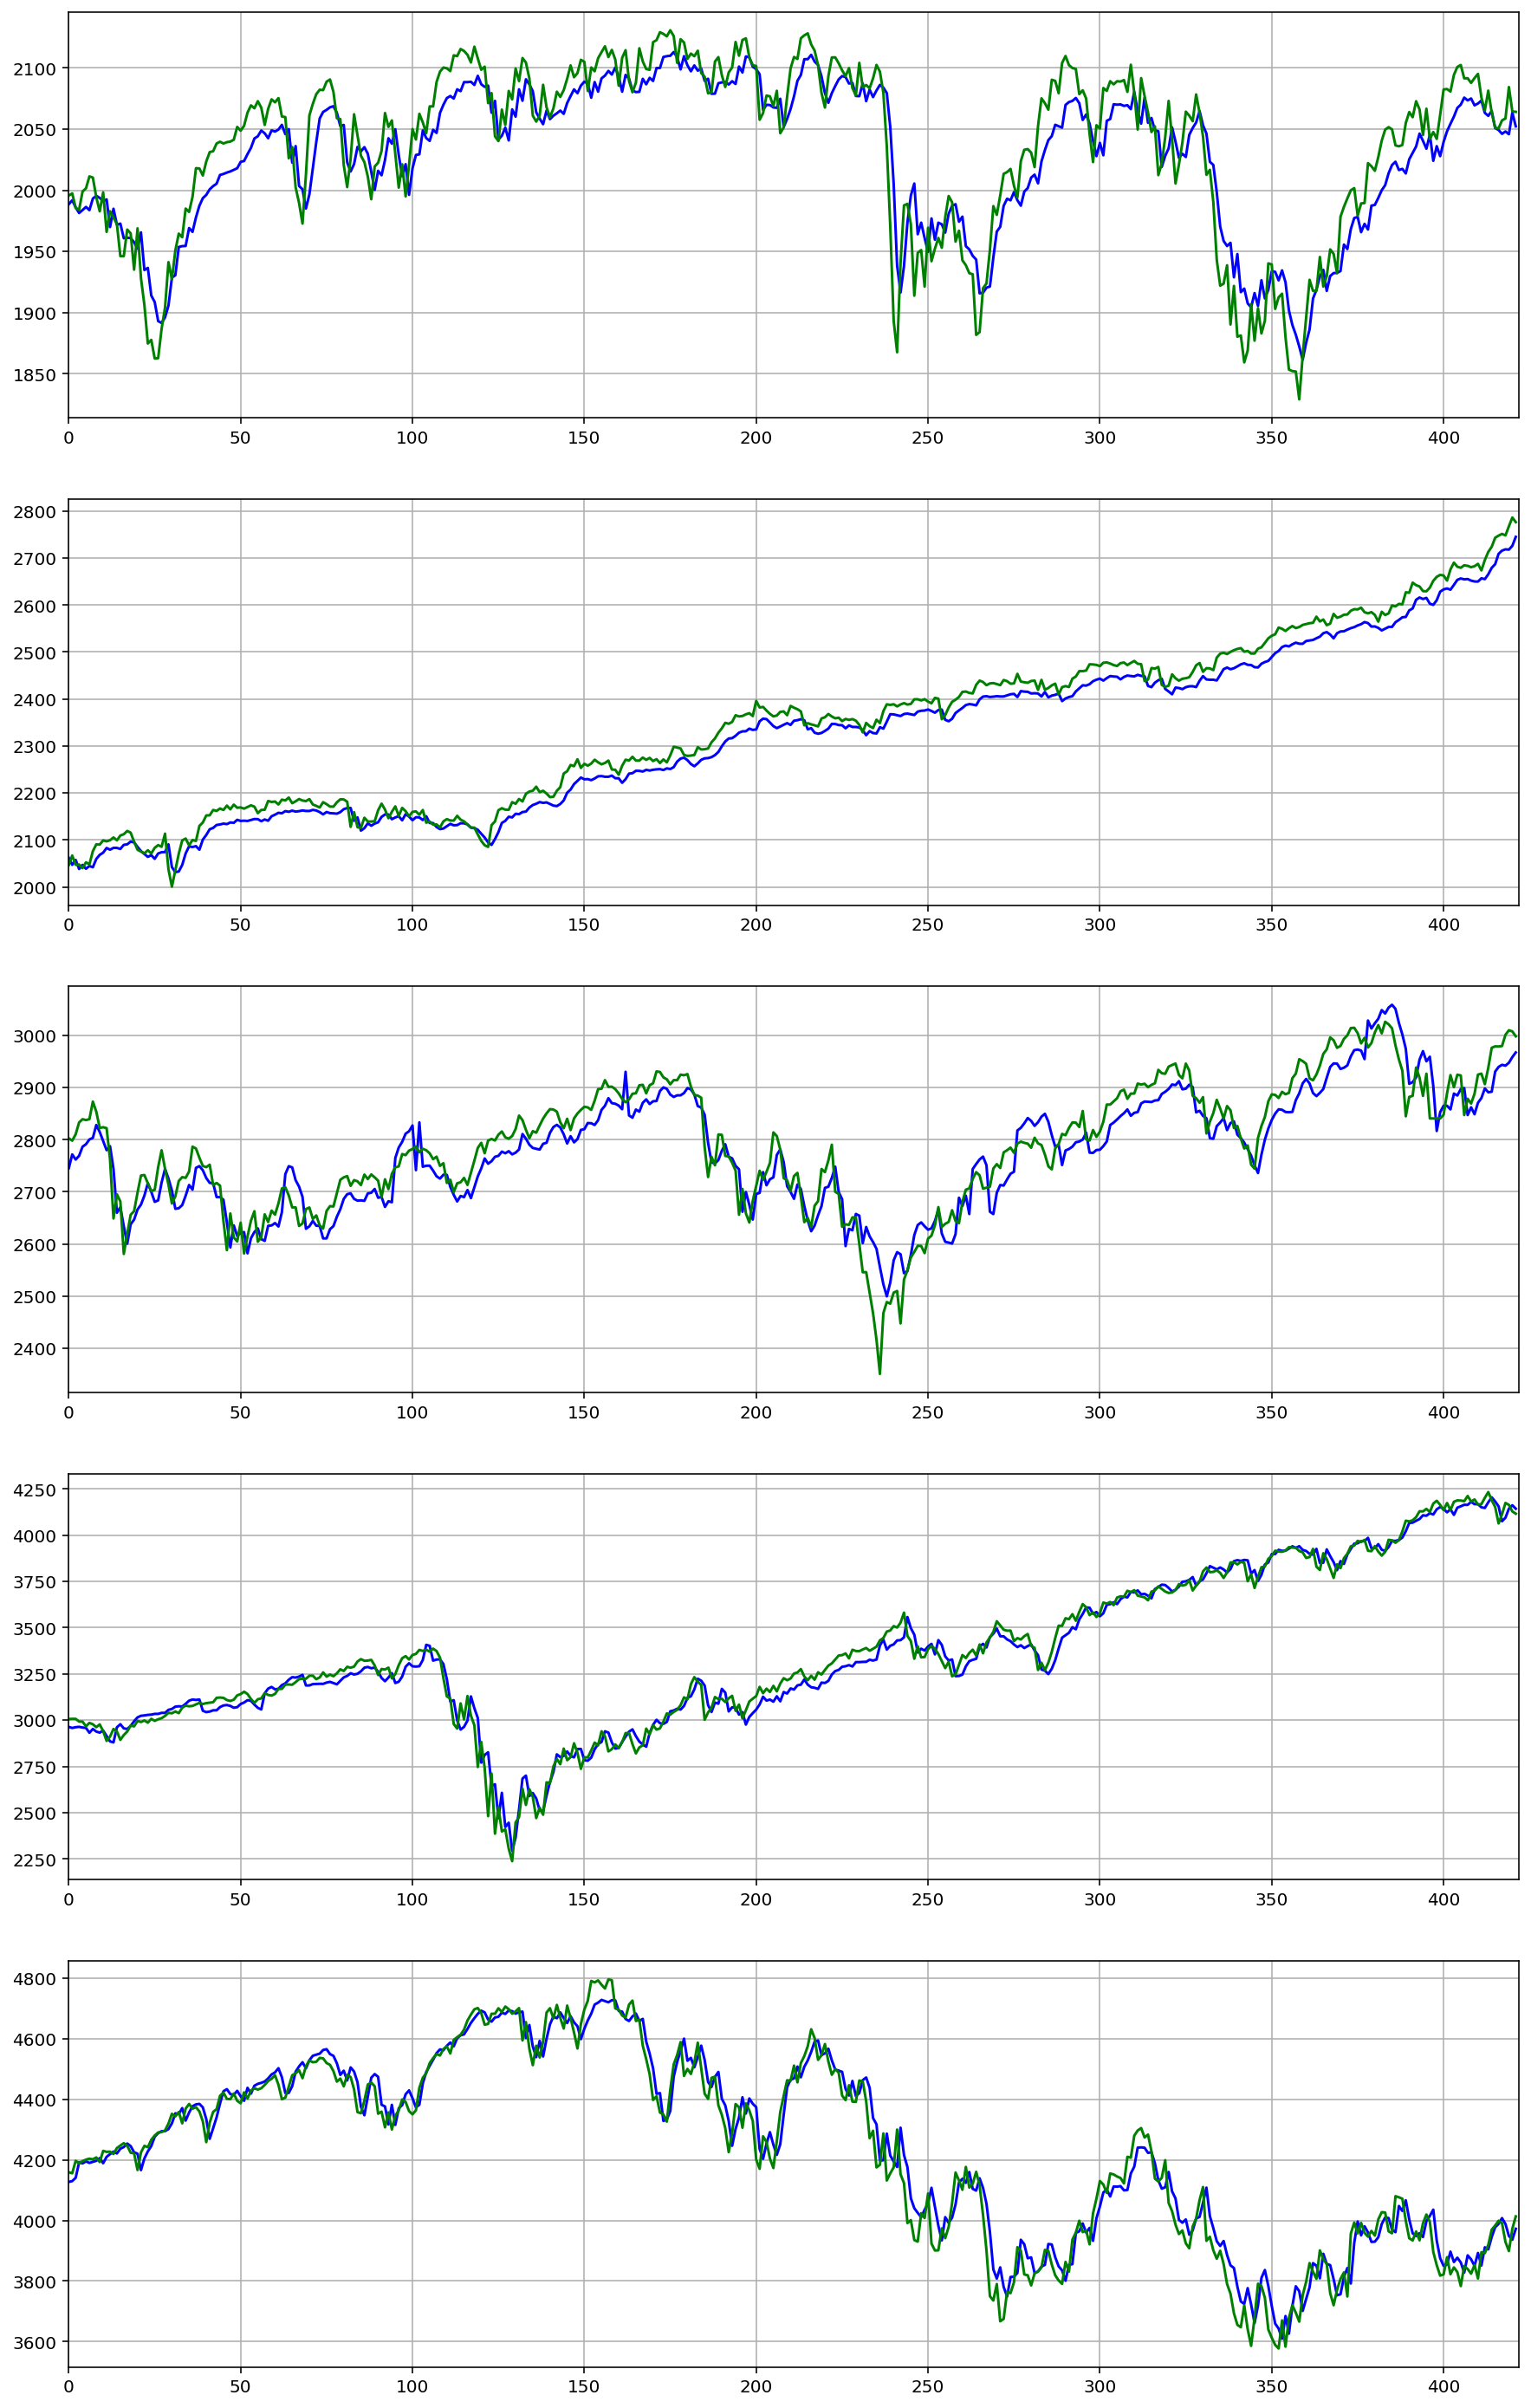

In [52]:
# Create 1 subplot for every "2" years
fig, ax = plt.subplots(5, figsize = (15,25))

for i in range(5):
    ax[i].plot(y_pred_on_test[i * 422: (i + 1) * 422], label = "y_pred_of_test", c = "blue")
    ax[i].plot(y_test[i * 422: (i + 1) * 422], label = "y_test", c = "g")
    ax[i].grid(True)
    ax[i].set_xlim([0,422])


# Strategy 1

The strategy is that if the predicted value for today is higher than the close value for the previous day, then we buy in the morning, and then we will automatically sell at what the close price for that day is.


In [53]:
# Create DF to compare the actual prices and the predicted prices
df_predicted = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
df_actual = pd.DataFrame(y_test, columns = ['Actual Close'])

In [54]:
df_store = pd.DataFrame.join(df_actual, df_predicted, how = 'left')

In [55]:
df_from_pred = df[['open']][8689:]
df_from_pred = df_from_pred.reset_index()

In [56]:
df_from_pred = df_from_pred.drop('Date', axis=1)
df_store = pd.merge(df_store, df_from_pred, left_index = True, right_index = True)

In [57]:
df_store

Actual Close  Predicted Close     open
0          1995.69      1988.593485  2000.73
1          1997.45      1991.825390  1988.41
2          1985.54      1986.015844  1992.85
3          1984.13      1981.430604  1996.74
4          1998.98      1983.839409  1986.04
...            ...              ...      ...
2105       3990.97      4007.747824  3960.60
2106       3928.86      3988.132456  3999.28
2107       3898.85      3948.779947  4002.25
2108       3972.61      3936.289909  3911.84
2109       4013.35      3972.429534  3909.04

[2110 rows x 3 columns]

In [58]:
# We shift down by one, as our "buy" signal is when the predicted close for the next day, is higher than the current
df_store['Predicted Close'] = df_store['Predicted Close'].shift(-1)
df_store.rename(columns = {'Predicted Close': 'Predicted Close d+1'}, inplace = True)

In [59]:
df_store = df_store.dropna()

In [60]:
df_store.head()

Actual Close  Predicted Close d+1     open
0       1995.69          1991.825390  2000.73
1       1997.45          1986.015844  1988.41
2       1985.54          1981.430604  1992.85
3       1984.13          1983.839409  1996.74
4       1998.98          1986.374694  1986.04

In [61]:
# Create an empty column to store the signal
df_store['signal'] = np.nan

# Sets the signal, if the prediction for the next day is greater than the current close, then assign 1.
for i in range(len(df_store)):
    if (df_store.iloc[i][1] - df_store.iloc[i][2]) >= 0:
        df_store['signal'].iloc[i] = 1
    else:
        df_store['signal'].iloc[i] = -1

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_1935/3547608008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['signal'] = np.nan
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_1935/3547608008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['signal'].iloc[i] = -1
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_1935/3547608008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

# Test strategy

In [471]:
# Create a copy table
df_results = df_store.copy()

#Create empty col

df_results['strat returns'] = np.nan
df_results['strat returns'].iloc[0] = 0

for i in range(1, len(df_store)-1):
    if df_results['signal'].iloc[i] > 0:
        # In this run through we will use the open value 
        df_results['strat returns'].iloc[i] = df_results['Actual Close'].iloc[i] - df_results['open'].iloc[i]
    elif df_results['signal'].iloc[i] < 0:
        df_results['strat returns'].iloc[i] = 0
#     df_results['investment'].iloc[i] = df_results['investment'].iloc[i-1] * (1 + (df_results['p/l'].iloc[i] / df_results['Actual Close'].iloc[i - 1]))

KeyError: 'signal'

In [63]:
df_results['return'] = df_results['Actual Close'] - df_results['Actual Close'].shift(1)

In [64]:
df_results

Actual Close  Predicted Close d+1     open  signal  strat returns  \
0          1995.69          1991.825390  2000.73    -1.0           0.00   
1          1997.45          1986.015844  1988.41    -1.0           0.00   
2          1985.54          1981.430604  1992.85    -1.0           0.00   
3          1984.13          1983.839409  1996.74    -1.0           0.00   
4          1998.98          1986.374694  1986.04     1.0          12.94   
...            ...                  ...      ...     ...            ...   
2104       3999.09          4007.747824  3977.57     1.0          21.52   
2105       3990.97          3988.132456  3960.60     1.0          30.37   
2106       3928.86          3948.779947  3999.28    -1.0           0.00   
2107       3898.85          3936.289909  4002.25    -1.0           0.00   
2108       3972.61          3972.429534  3911.84     1.0            NaN   

      return  
0        NaN  
1       1.76  
2     -11.91  
3      -1.41  
4      14.85  
...      ...  
2104   15.92  
2105   -8.12  
2106  -62.11  
2107  -30.01  
2108   73.76  

[2109 rows x 6 columns]

In [65]:
df_results['strat relative change'] = (df_results['strat returns'] / df_results['Actual Close'])
df_results['buy hold relative change'] = (df_results['return'] / df_results['Actual Close'].shift(1))

In [66]:
df_results['return'].iloc[0] = 0
df_results.dropna()

Actual Close  Predicted Close d+1     open  signal  strat returns  \
1          1997.45          1986.015844  1988.41    -1.0           0.00   
2          1985.54          1981.430604  1992.85    -1.0           0.00   
3          1984.13          1983.839409  1996.74    -1.0           0.00   
4          1998.98          1986.374694  1986.04     1.0          12.94   
5          2001.57          1983.764894  1981.93     1.0          19.64   
...            ...                  ...      ...     ...            ...   
2103       3983.17          3988.577979  3932.35     1.0          50.82   
2104       3999.09          4007.747824  3977.57     1.0          21.52   
2105       3990.97          3988.132456  3960.60     1.0          30.37   
2106       3928.86          3948.779947  3999.28    -1.0           0.00   
2107       3898.85          3936.289909  4002.25    -1.0           0.00   

      return  strat relative change  buy hold relative change  
1       1.76               0.000000                  0.000882  
2     -11.91               0.000000                 -0.005963  
3      -1.41               0.000000                 -0.000710  
4      14.85               0.006473                  0.007484  
5       2.59               0.009812                  0.001296  
...      ...                    ...                       ...  
2103   13.56               0.012759                  0.003416  
2104   15.92               0.005381                  0.003997  
2105   -8.12               0.007610                 -0.002030  
2106  -62.11               0.000000                 -0.015563  
2107  -30.01               0.000000                 -0.007638  

[2107 rows x 8 columns]

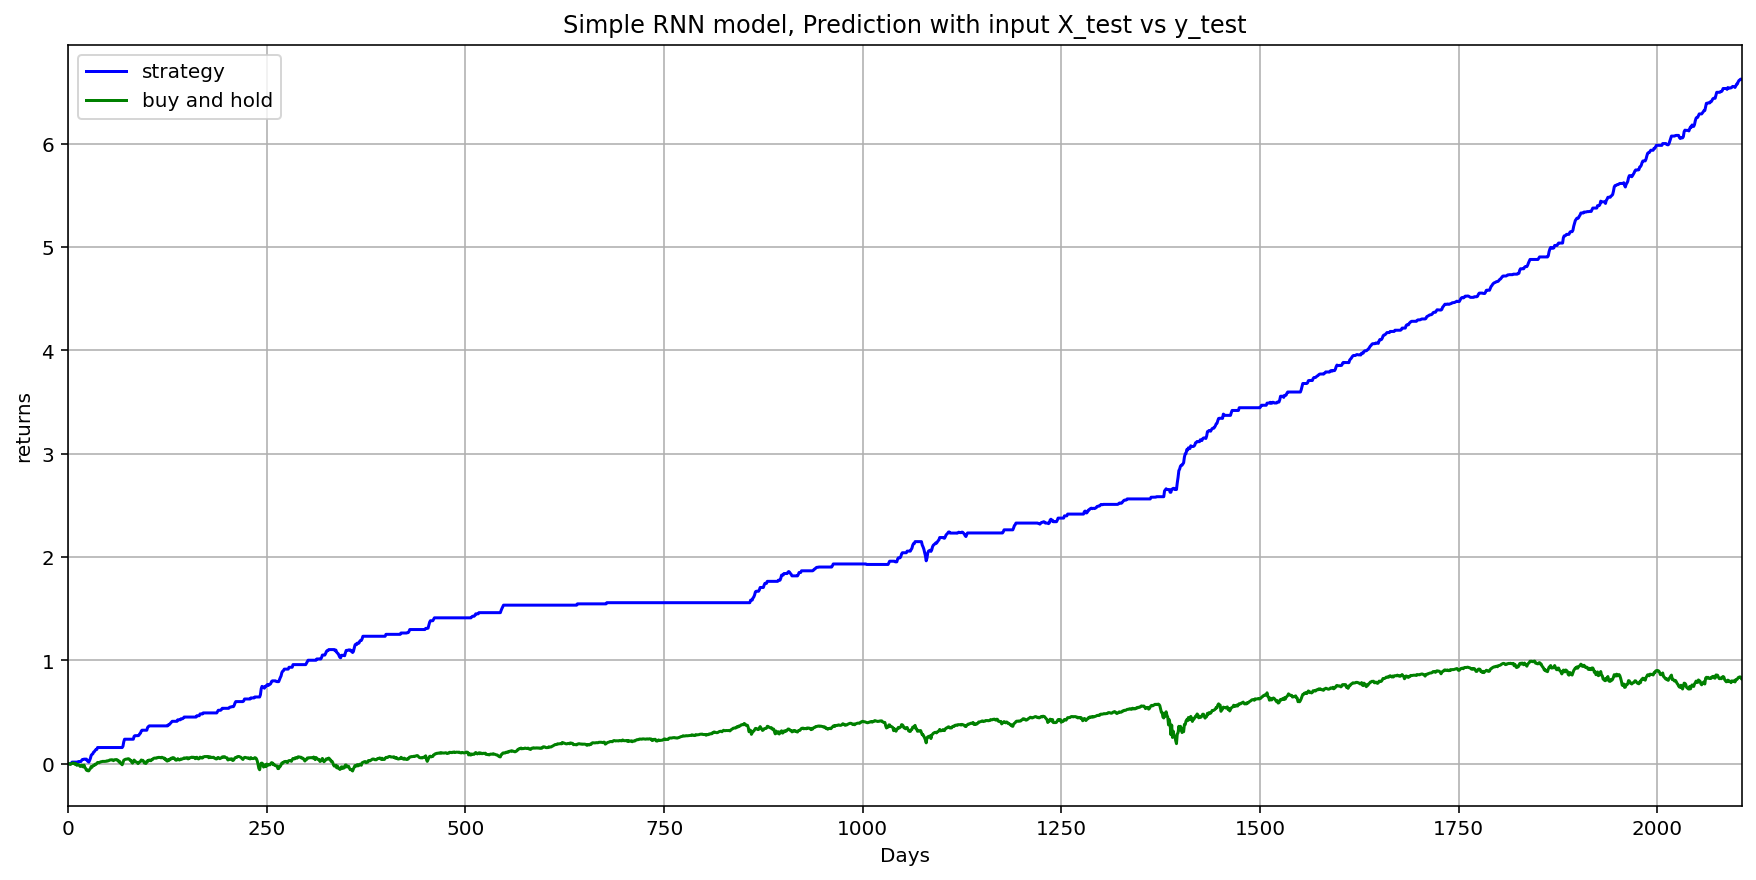

In [80]:
plt.figure(figsize = (15, 7))
plt.plot(df_results['strat relative change'].cumsum(), label = 'strategy', c = "blue")
plt.plot(df_results['buy hold relative change'].cumsum(), label = "buy and hold", c = "g")
plt.xlabel("Days")
plt.ylabel("returns")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlim([0,2107])
plt.show()

In [68]:
print('10 year return applying strategy:', 1 + df_results['strat relative change'].sum())
print('10 year return buy and hold:', 1 + df_results['buy hold relative change'].sum())

10 year return applying strategy: 7.624225091296206
10 year return buy and hold: 1.8349022784234872


In [69]:
# Invest 100,000 ~ 10 years ago
print(100000 * (1 + df_results['strat relative change'].sum()))
print(100000 * (1 + df_results['buy hold relative change'].sum()))

762422.5091296206
183490.22784234872


In [70]:
df_results['strat relative change'].sum() / df_results['buy hold relative change'].sum()

7.934132248153002

In [71]:
df_results.to_csv('output.csv')

# Backtesting the strategy

In [472]:
training_data.shape

(8639, 13)

In [473]:
num_arrays = 8639 // (252 * 2)

arrays = np.array_split(X_train, num_arrays)
target_arrays = np.array_split(y_train, num_arrays)

if not os.path.exists('saved_data'):
    os.makedirs('saved_data')

for i, array in enumerate(arrays):
    np.save(f"saved_data/X_train_{i}.npy", array)
    
target_arrays = np.array_split(y_train, num_arrays)
for k, array in enumerate(target_arrays):
    np.save(f"saved_data/y_train_{k}.npy", array)

In [474]:
# Note that we have 16 files saved here, make a prediction on each train set, and save
for i in range(num_arrays):
    X_train = np.load(os.path.join('saved_data', 'X_train_' + str(i) + '.npy'))
    y_train_pred = model.predict(X_train)
    y_train_pred = np.reshape(y_train_pred, (-1,1))
    np.save(f"saved_data/y_train_pred_{i}.npy", y_train_pred)

16/16 [==============================] - 0s 9ms/step


In [475]:
src = 'saved_data/'

# Each of our saved files will contain the predictions for the n-th year in the correct format
# Here we unscale our preidction values
for filename in os.listdir(src):
    if filename.split('_')[0] == 'y' and filename.split('_')[2] == 'pred':
        i = filename.split('_')[3]
        y_pred = np.load(os.path.join(src, filename))
        y_train_dataset_like = np.zeros(shape = (len(y_pred), 13))
        y_train_dataset_like[:,0] = y_pred[:,0]
        y_train_set = scaler.inverse_transform(y_train_dataset_like)[:,0]
        y_train_set = np.reshape(y_train_set, (-1,1))
        np.save(f"saved_data/y_pred_{i}", y_train_set)

In [477]:
# # Now we can load the first 5 years and plot the prediction vs the actual data
# fig, ax = plt.subplots(5, figsize = (15,25))

# for filename in os.listdir(src):
#     if filename.split('_')[0] == 'y'and filename.split('_')[1] == 'pred':
#         while int(filename.split('_')[2]) > 9 and int(filename.split('_')[2]) < 5:

In [478]:
X = np.load('saved_data/X_train_0.npy')
y = np.load('saved_data/y_train_0.npy')
print(X.shape)
print(y.shape)

(506, 50, 13)
(506, 1)


In [479]:
y

array([[1842.13758921],
       [1841.97376361],
       [1842.46524042],
       [1839.84403078],
       [1838.86107716],
       [1839.51637957],
       [1840.49933319],
       [1843.12054283],
       [1842.30141482],
       [1841.97376361],
       [1839.02490276],
       [1840.17168198],
       [1841.4822868 ],
       [1844.43114765],
       [1845.74175247],
       [1844.92262446],
       [1845.25027566],
       [1843.44819403],
       [1844.92262446],
       [1848.52678771],
       [1847.3800085 ],
       [1847.8714853 ],
       [1850.82034615],
       [1851.80329977],
       [1852.62242778],
       [1852.13095097],
       [1851.63947416],
       [1851.47564856],
       [1849.83739254],
       [1850.82034615],
       [1852.45860218],
       [1852.13095097],
       [1851.31182296],
       [1850.49269495],
       [1850.16504374],
       [1849.67356693],
       [1851.14799736],
       [1853.9330326 ],
       [1854.42450941],
       [1856.39041664],
       [1854.75216061],
       [1853.933

In [480]:
arrays, target_arrays = [], []
for i in range(17):
    arrays.append(np.load('saved_data/y_pred_{}.npy'.format(i)))
    target_arrays.append(np.load('saved_data/y_train_{}.npy'.format(i)))
    
selected_arrays, selected_target_arrays = arrays[10:15], target_arrays[10:15]

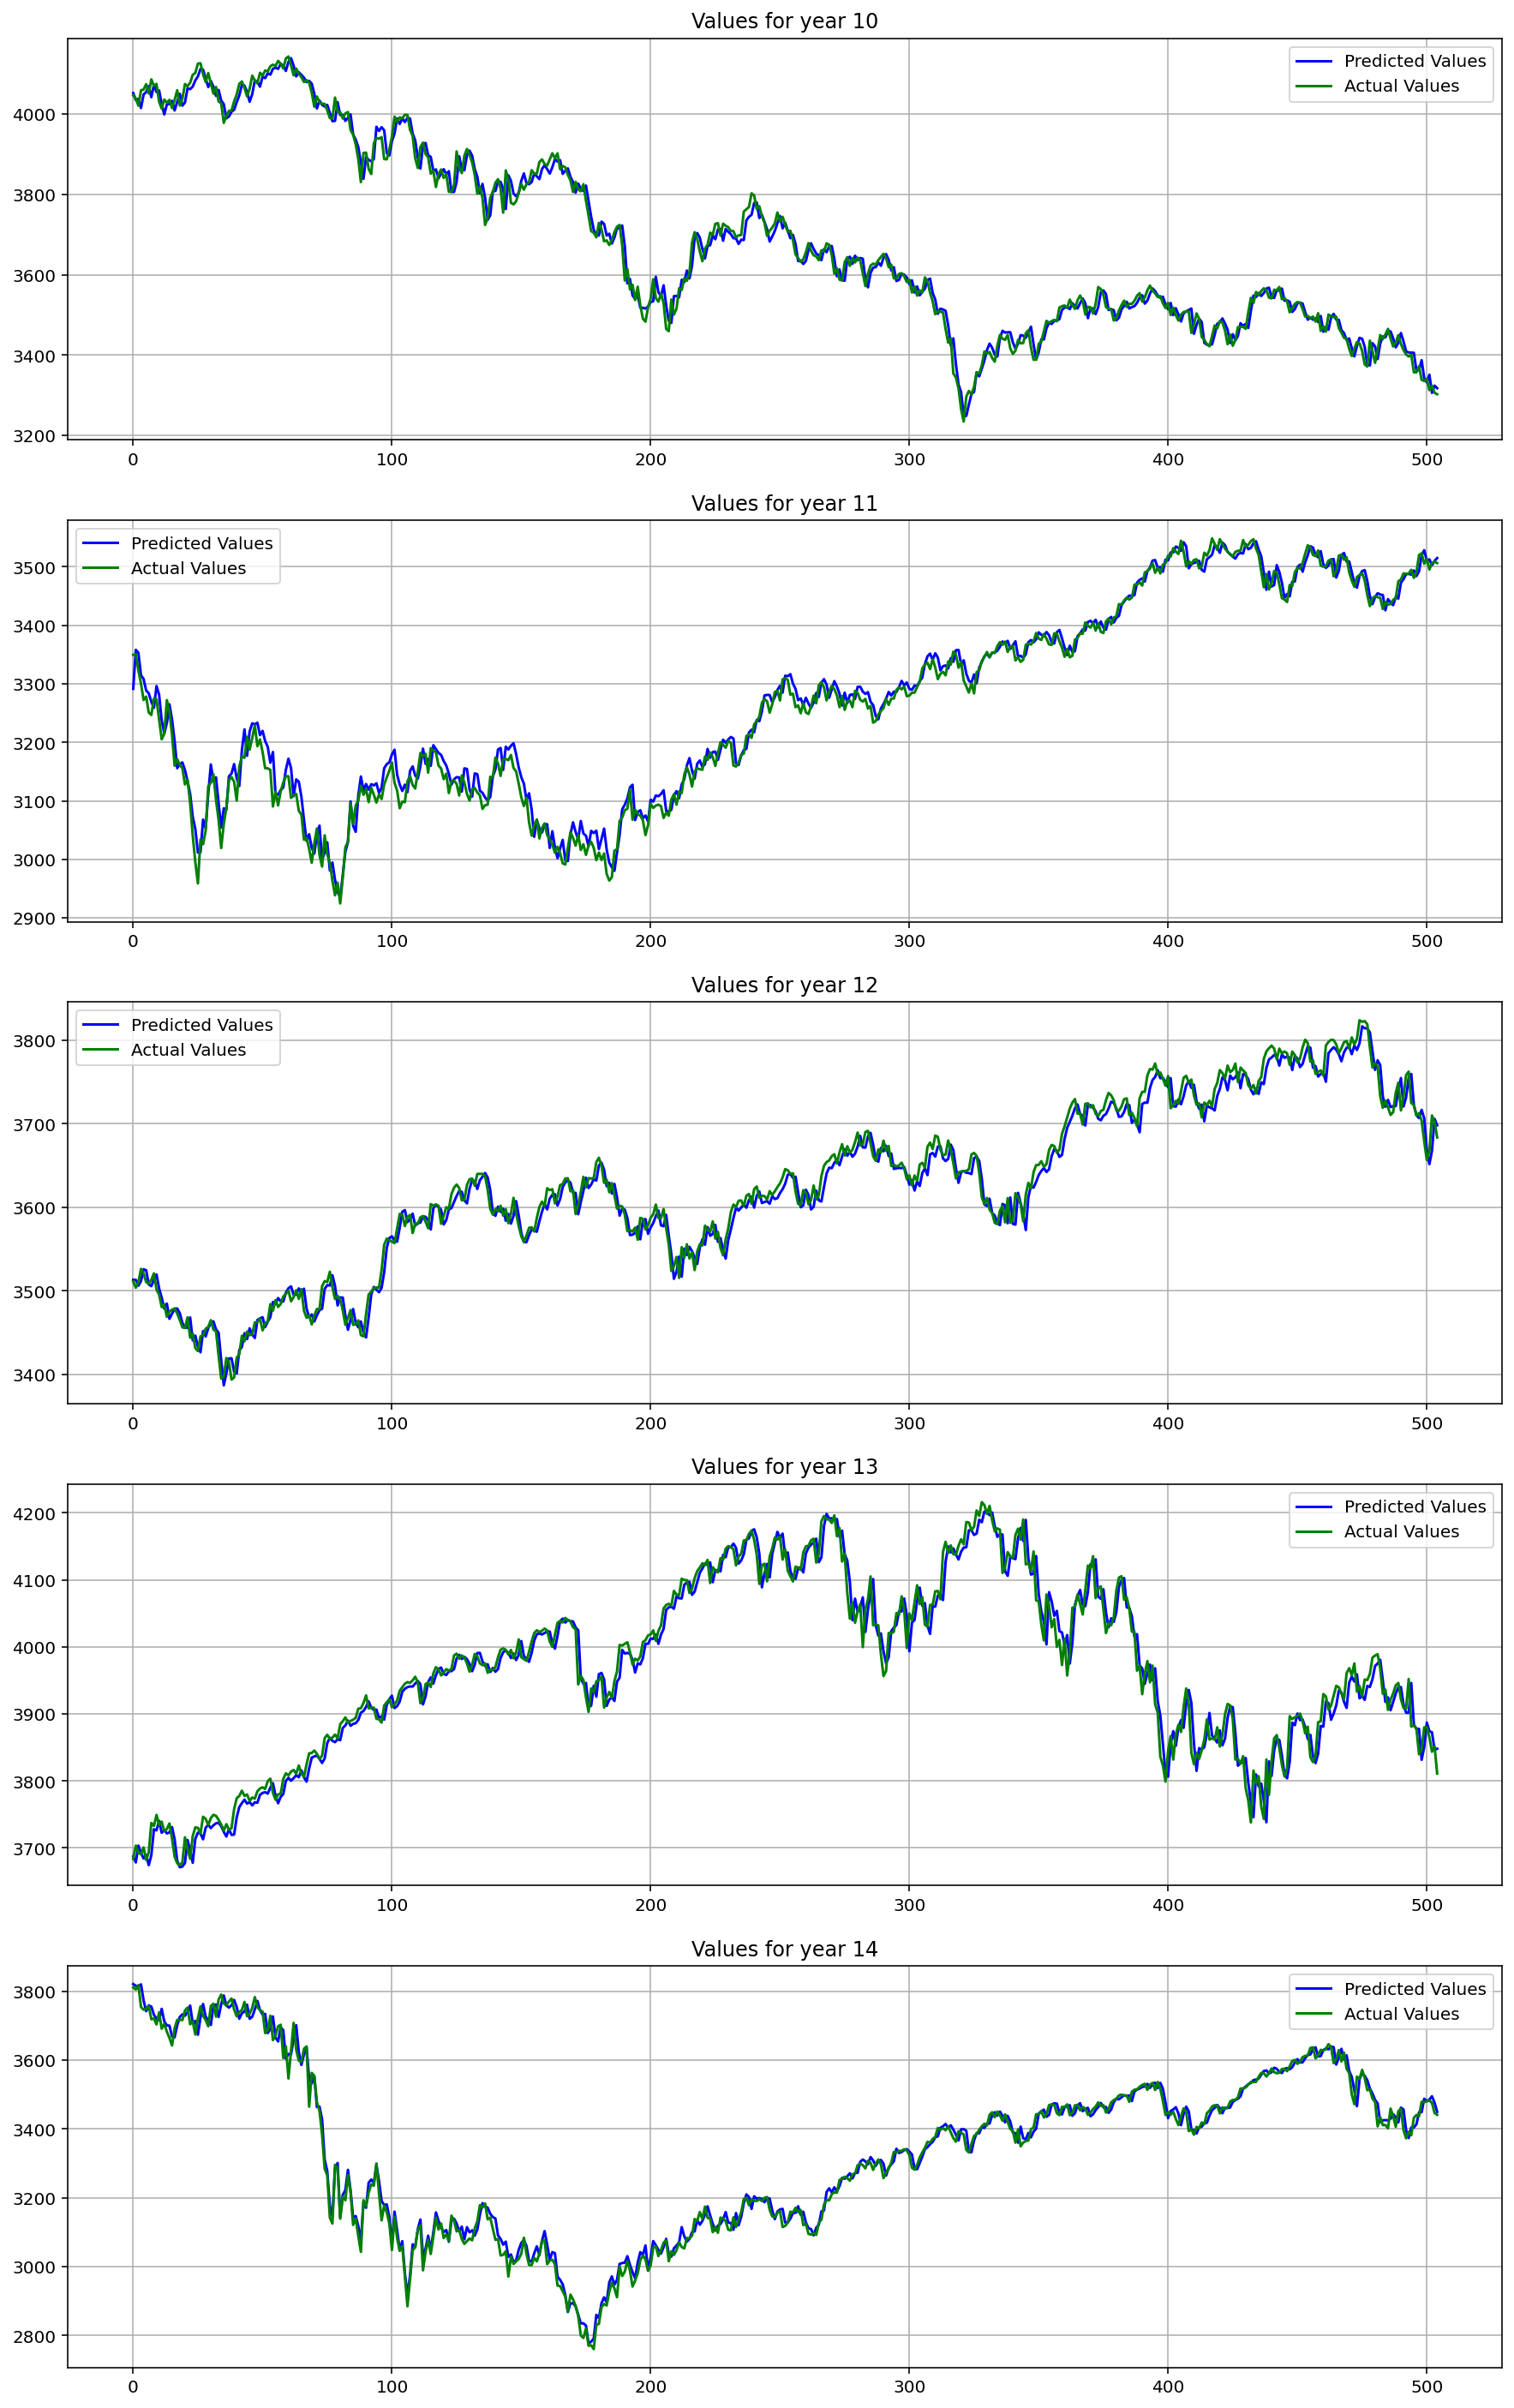

In [481]:
fig, ax = plt.subplots(5, figsize = (15,25))

for i, ax in enumerate(ax):
    ax.plot(selected_arrays[i], label = "Predicted Values", c = 'blue')
    ax.plot(selected_target_arrays[i], label = "Actual Values", c = 'g')
    ax.grid(True)
    ax.legend()
    ax.set_title('Values for year {}'.format(i + 10))

To avoid confusion, as we have a lot of arrays floating, y_pred_i is our unscaled prediction set, and y_train_i is the actual values

# Import the strategy

In [482]:
list_store = []

df_open_price = df[['open']][:8680]

split_dfs = np.array_split(df_open_price, num_arrays)

for i in range(num_arrays):
    df_predicted = pd.DataFrame(np.load(os.path.join(src, 'y_pred_{}.npy'.format(i))), columns = ['Predicted Close'])
    df_train = pd.DataFrame(np.load(os.path.join(src, 'y_train_{}.npy'.format(i))), columns = ['Actual Close'])
    df_merge = pd.DataFrame.join(df_predicted, df_train, how = 'left')
    df_open = split_dfs[i]
    df_open = df_open.reset_index()
    df_open = df_open.drop('Date', axis = 1)
    df_store = pd.merge(df_merge, df_open, left_index = True, right_index = True)
    list_store.append(df_store)
    
for i, df in enumerate(list_store):
    filename = 'df_store_' + str(i) + '.csv'
    filepath = os.path.join(src, filename)
    df.to_csv(filepath, index = False)

In [485]:
test = pd.read_csv('saved_data/df_store_0.csv')
test.head()

Predicted Close  Actual Close   open
0      1853.164972   1842.137589  102.7
1      1853.138990   1841.973764  102.2
2      1849.389596   1842.465240  100.2
3      1850.930102   1839.844031  101.2
4      1844.381285   1838.861077  103.1

In [416]:
df_predicted_12 = pd.DataFrame(np.load(os.path.join(src, 'y_pred_12.npy')))
df_predicted_12.head()

0
0  3499.866364
1  3499.794937
2  3493.937153
3  3502.859036
4  3519.511538

In [427]:
df_test = split_dfs[12].reset_index()
df_test = df_test.drop('Date', axis = 1)

In [389]:
# Create DF to compare the actual prices and the predicted prices
df_predicted_back = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
df_actual_back = pd.DataFrame(y_test, columns = ['Actual Close'])
# Join tables
df_store_back = pd.DataFrame.join(df_actual, df_predicted, how = 'left')
# Adding the Actual open data
df_from_test_back = df[['open']][8689:]
df_from_test_back = df_from_test_back.reset_index()
# Join tables
df_from_test_back = df_from_test_back.drop('Date', axis=1)
df_store_back = pd.merge(df_store_back, df_from_test_back, left_index = True, right_index = True)

In [396]:
df_store_back.head()

Actual Close  Predicted Close     open
0       1995.69      2004.430633  2000.73
1       1997.45      2008.659474  1988.41
2       1985.54      2006.713154  1992.85
3       1984.13      2005.669058  1996.74
4       1998.98      2005.350603  1986.04

In [392]:
df_store = df_store_back.copy()

In [393]:
# We shift down by one, as our "buy" signal is when the predicted close for the next day, is higher than the current
df_store['Predicted Close'] = df_store['Predicted Close'].shift(-1)
df_store.rename(columns = {'Predicted Close': 'Predicted Close d+1'}, inplace = True)
df_store = df_store.dropna()

In [398]:
# Create an empty column to store the signal
df_store['signal'] = np.nan

# Sets the signal, if the prediction for the next day is greater than the current close, then assign 1.
for i in range(len(df_store)):
    if (df_store.iloc[i][1] - df_store.iloc[i][2]) >= 0:
        df_store['signal'].iloc[i] = 1
    else:
        df_store['signal'].iloc[i] = -1

# Test strategy

In [399]:
# Create a copy table
df_results = df_store.copy()

#Create empty col

df_results['strat returns'] = np.nan
df_results['strat returns'].iloc[0] = 0

for i in range(1, len(df_store)-1):
    if df_results['signal'].iloc[i] > 0:
        # In this run through we will use the open value 
        df_results['strat returns'].iloc[i] = df_results['Actual Close'].iloc[i] - df_results['open'].iloc[i]
    elif df_results['signal'].iloc[i] < 0:
        df_results['strat returns'].iloc[i] = 0

In [400]:
df_results['return'] = df_results['Actual Close'] - df_results['Actual Close'].shift(1)

In [912]:
df_store = pd.DataFrame.join(df_actual, df_predicted, how = 'left')

In [913]:
df_store.head()

Actual Close  Predicted Close
0   2109.664798      2108.362118
1   2105.732984      2116.984911
2   2115.398694      2107.912183
3   2116.709299      2114.440704
4   2114.415741      2120.547232

In [914]:
df_from_pred = df[['open']][5 * 422:6 * 422]
df_from_pred = df_from_pred.reset_index()

In [915]:
df_from_pred = df_from_pred.drop('Date', axis=1)
df_store = pd.merge(df_store, df_from_pred, left_index = True, right_index = True)

In [916]:
df_store.head()

Actual Close  Predicted Close   open
0   2109.664798      2108.362118  271.9
1   2105.732984      2116.984911  271.1
2   2115.398694      2107.912183  270.0
3   2116.709299      2114.440704  266.5
4   2114.415741      2120.547232  261.9

# Strategy 2

We will now try the same approach but using a shorter timespan for the model, i.e. 30 days instead of 50

In [923]:
# Create the training data
X_train, y_train = [], []

# Set the time step to 30 instead of 50
time_step = 30

length_train = 8639 # length data * 0.8

# This step is necessary to pass into a RNN
for i in range(time_step, length_train):
    X_train.append(training_scaled[i - time_step : i, :])
    y_train.append(training_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [924]:
# Create the test data
X_test, y_test = [], []

length_train = test_data.shape[0]

for i in range(time_step, length_train):
    X_test.append(testing_scaled[i - time_step : i, :])
    y_test.append(testing_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [925]:
print(X_train.shape)
print(y_train.shape)

(8609, 30, 13)
(8609,)


In [926]:
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (-1,1))

In [936]:
# We use the same model parameters so there is no need to redefine them
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
270/270 [==============================] - 5s 11ms/step - loss: 0.0270 - accuracy: 0.0000e+00
Epoch 2/100
270/270 [==============================] - 3s 11ms/step - loss: 0.0046 - accuracy: 0.0000e+00
Epoch 3/100
270/270 [==============================] - 3s 12ms/step - loss: 0.0036 - accuracy: 0.0000e+00
Epoch 4/100
270/270 [==============================] - 3s 12ms/step - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 5/100
270/270 [==============================] - 3s 12ms/step - loss: 0.0016 - accuracy: 0.0000e+00
Epoch 6/100
270/270 [==============================] - 3s 13ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 7/100
270/270 [==============================] - 3s 12ms/step - loss: 0.0013 - accuracy: 0.0000e+00
Epoch 8/100
270/270 [==============================] - 3s 12ms/step - loss: 0.0015 - accuracy: 0.0000e+00
Epoch 9/100
270/270 [==============================] - 3s 13ms/step - loss: 0.0010 - accuracy: 0.0000e+00
Epoch 10/100
270/270 [========================

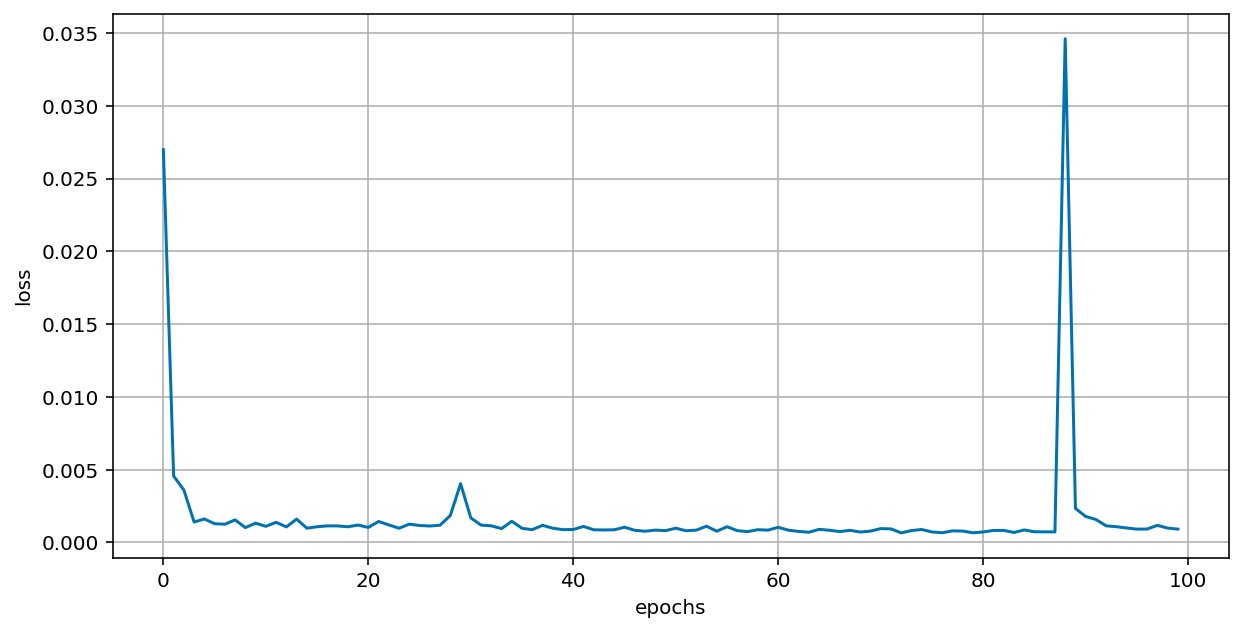

In [937]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [938]:
testing_scaled.shape

(2160, 13)

In [939]:
model.evaluate(X_test, y_test)

67/67 [==============================] - 1s 4ms/step - loss: 0.0059 - accuracy: 0.0000e+00


[0.0059258402325212955, 0.0]

Note that the performace using 30 days is slightly worse than when we use 50 days

In [940]:
y_pred = model.predict(X_train)

# create empty table with 13 fields (same number of columns)
y_pred_dataset_like = np.zeros(shape=(len(y_pred), 13) )

# put the predicted values in the right field
y_pred_dataset_like[:,0] = y_pred[:,0]
# inverse transform and then select the right field
y_pred = scaler.inverse_transform(y_pred_dataset_like)[:,0]

y_pred = np.reshape(y_pred, (y_pred.shape[0],1))

print(y_pred.shape)

270/270 [==============================] - 1s 4ms/step
(8609, 1)


In [941]:
# create empty table with 13 fields
y_train_dataset_like = np.zeros(shape=(len(y_train), 13) )

# put the predicted values in the right field
y_train_dataset_like[:,0] = y_train[:,0]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(y_train_dataset_like)[:,0]

y_train = np.reshape(y_train, (y_train.shape[0],1))

print(y_train.shape)

(8609, 1)


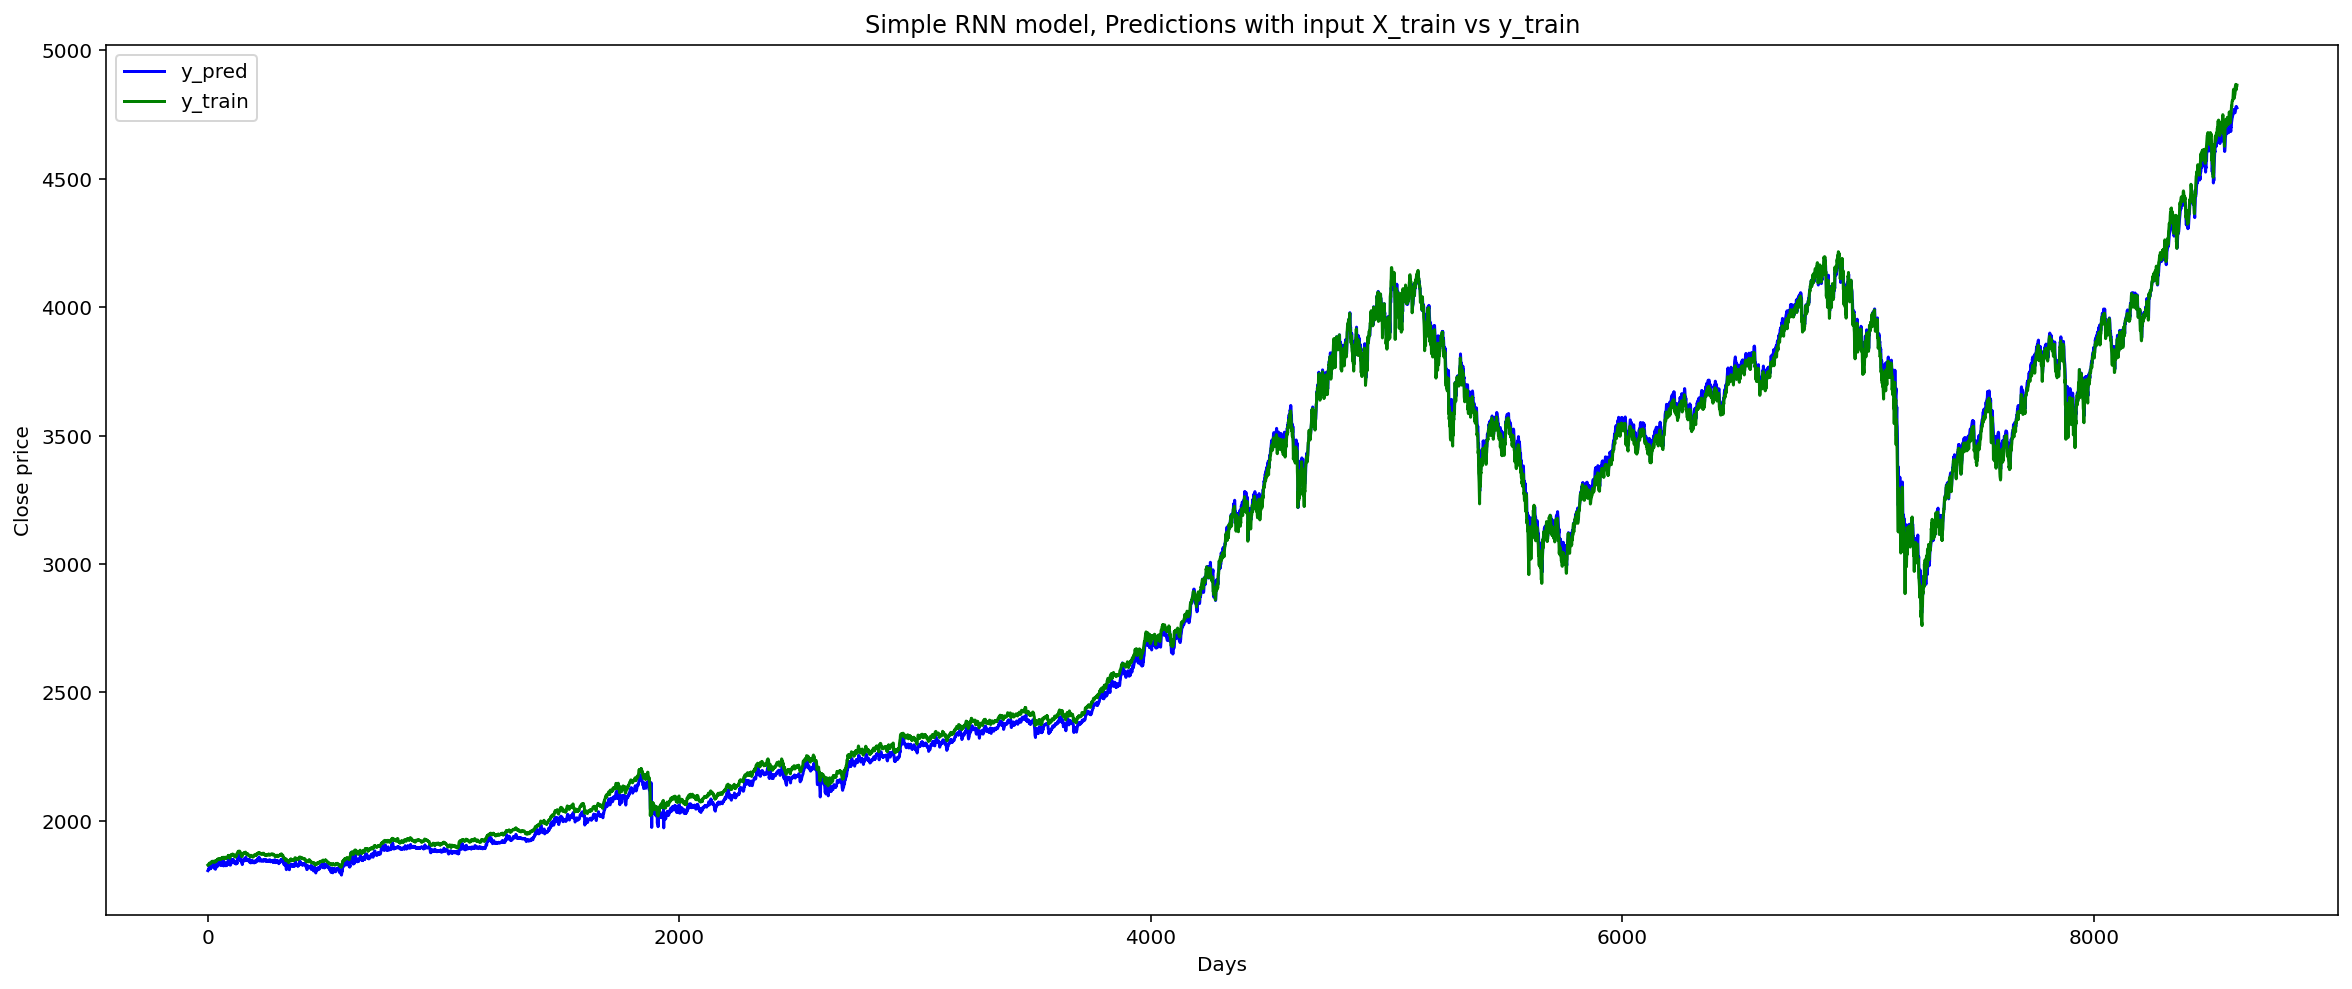

In [942]:
plt.figure(figsize = (20,8))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [943]:
y_pred_on_test = model.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

67/67 [==============================] - 0s 5ms/step


In [944]:
# create empty table with 13 fields
y_test_pred_dataset_like = np.zeros(shape=(len(y_pred_on_test), 13))

# put the predicted values in the right field
y_test_pred_dataset_like[:,0] = y_pred_on_test[:,0]
# inverse transform and then select the right field
y_pred_on_test = scaler.inverse_transform(y_test_pred_dataset_like)[:,0]

y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

print(y_pred_on_test.shape)

(2130, 1)


In [945]:
# create empty table with 13 fields
y_test_dataset_like = np.zeros(shape=(len(y_test), 13))

# put the predicted values in the right field
y_test_dataset_like[:,0] = y_test[:,0]
# inverse transform and then select the right field
y_test = scaler.inverse_transform(y_test_dataset_like)[:,0]

y_test = np.reshape(y_test, (-1,1))

print(y_test.shape)

(2130, 1)


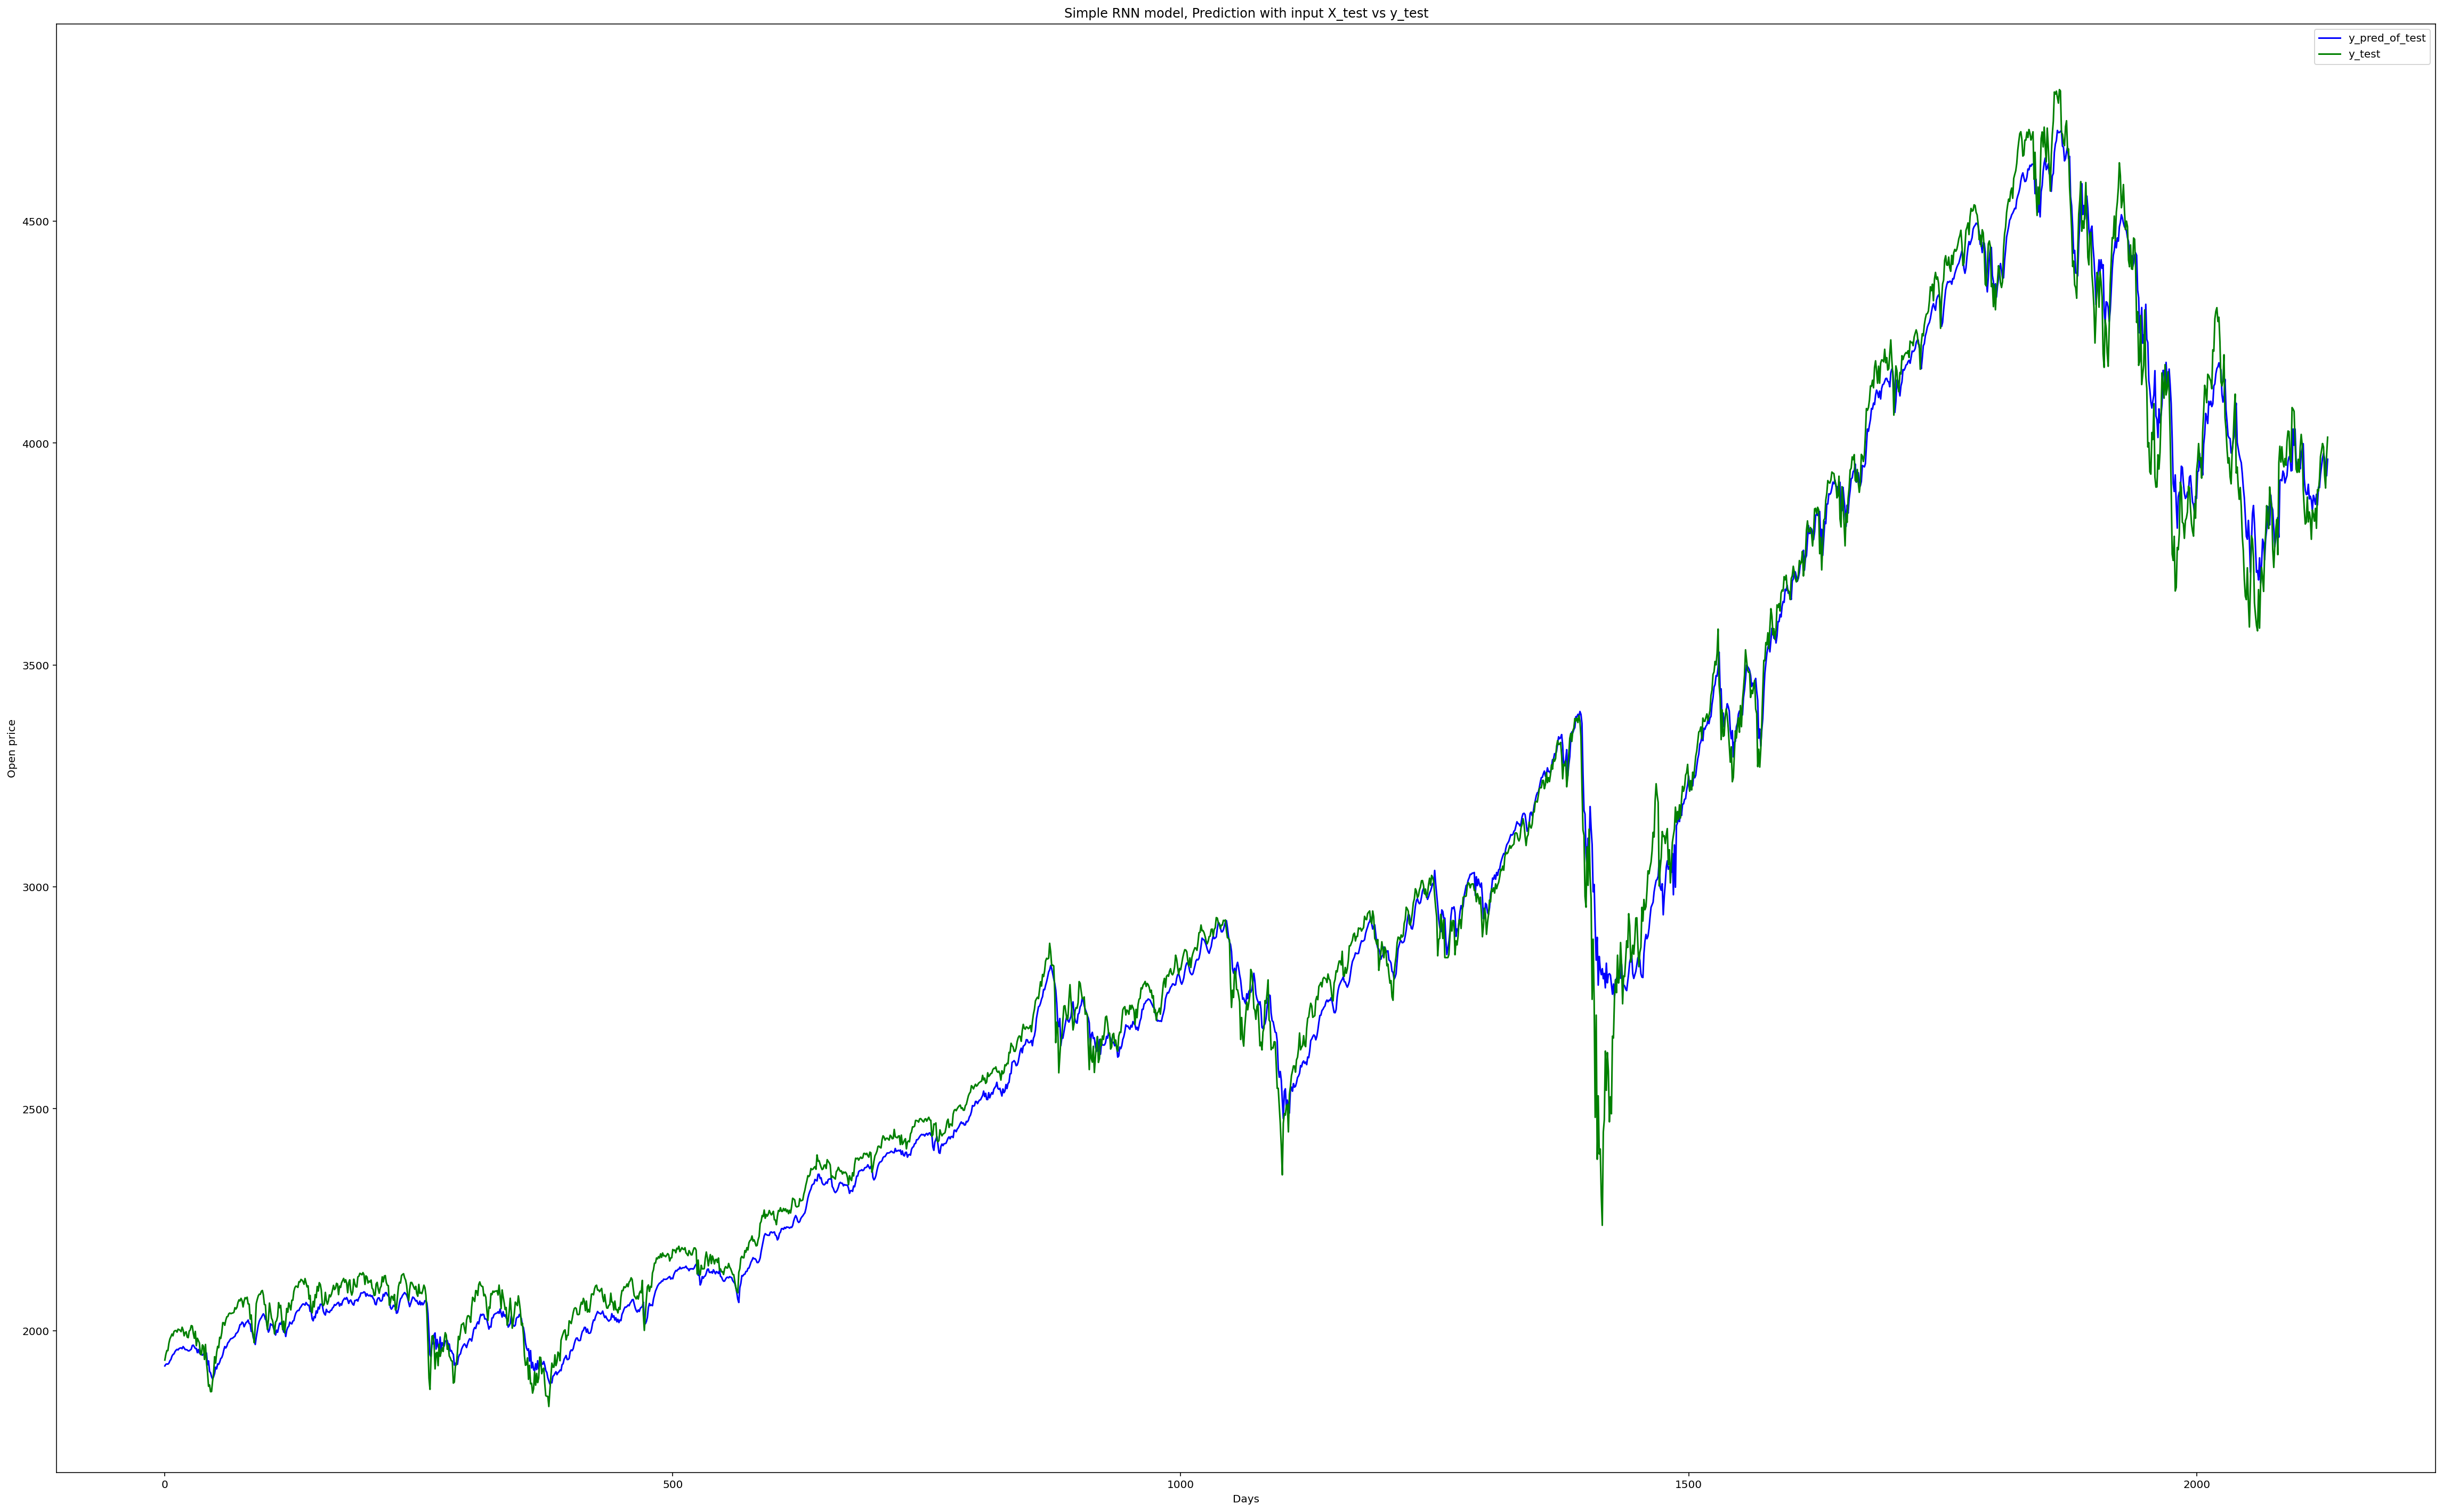

In [946]:
plt.figure(figsize = (40,25))
plt.plot(y_pred_on_test, label = "y_pred_of_test", c = "blue")
plt.plot(y_test, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [947]:
y_test.shape[0]/ 5

426.0

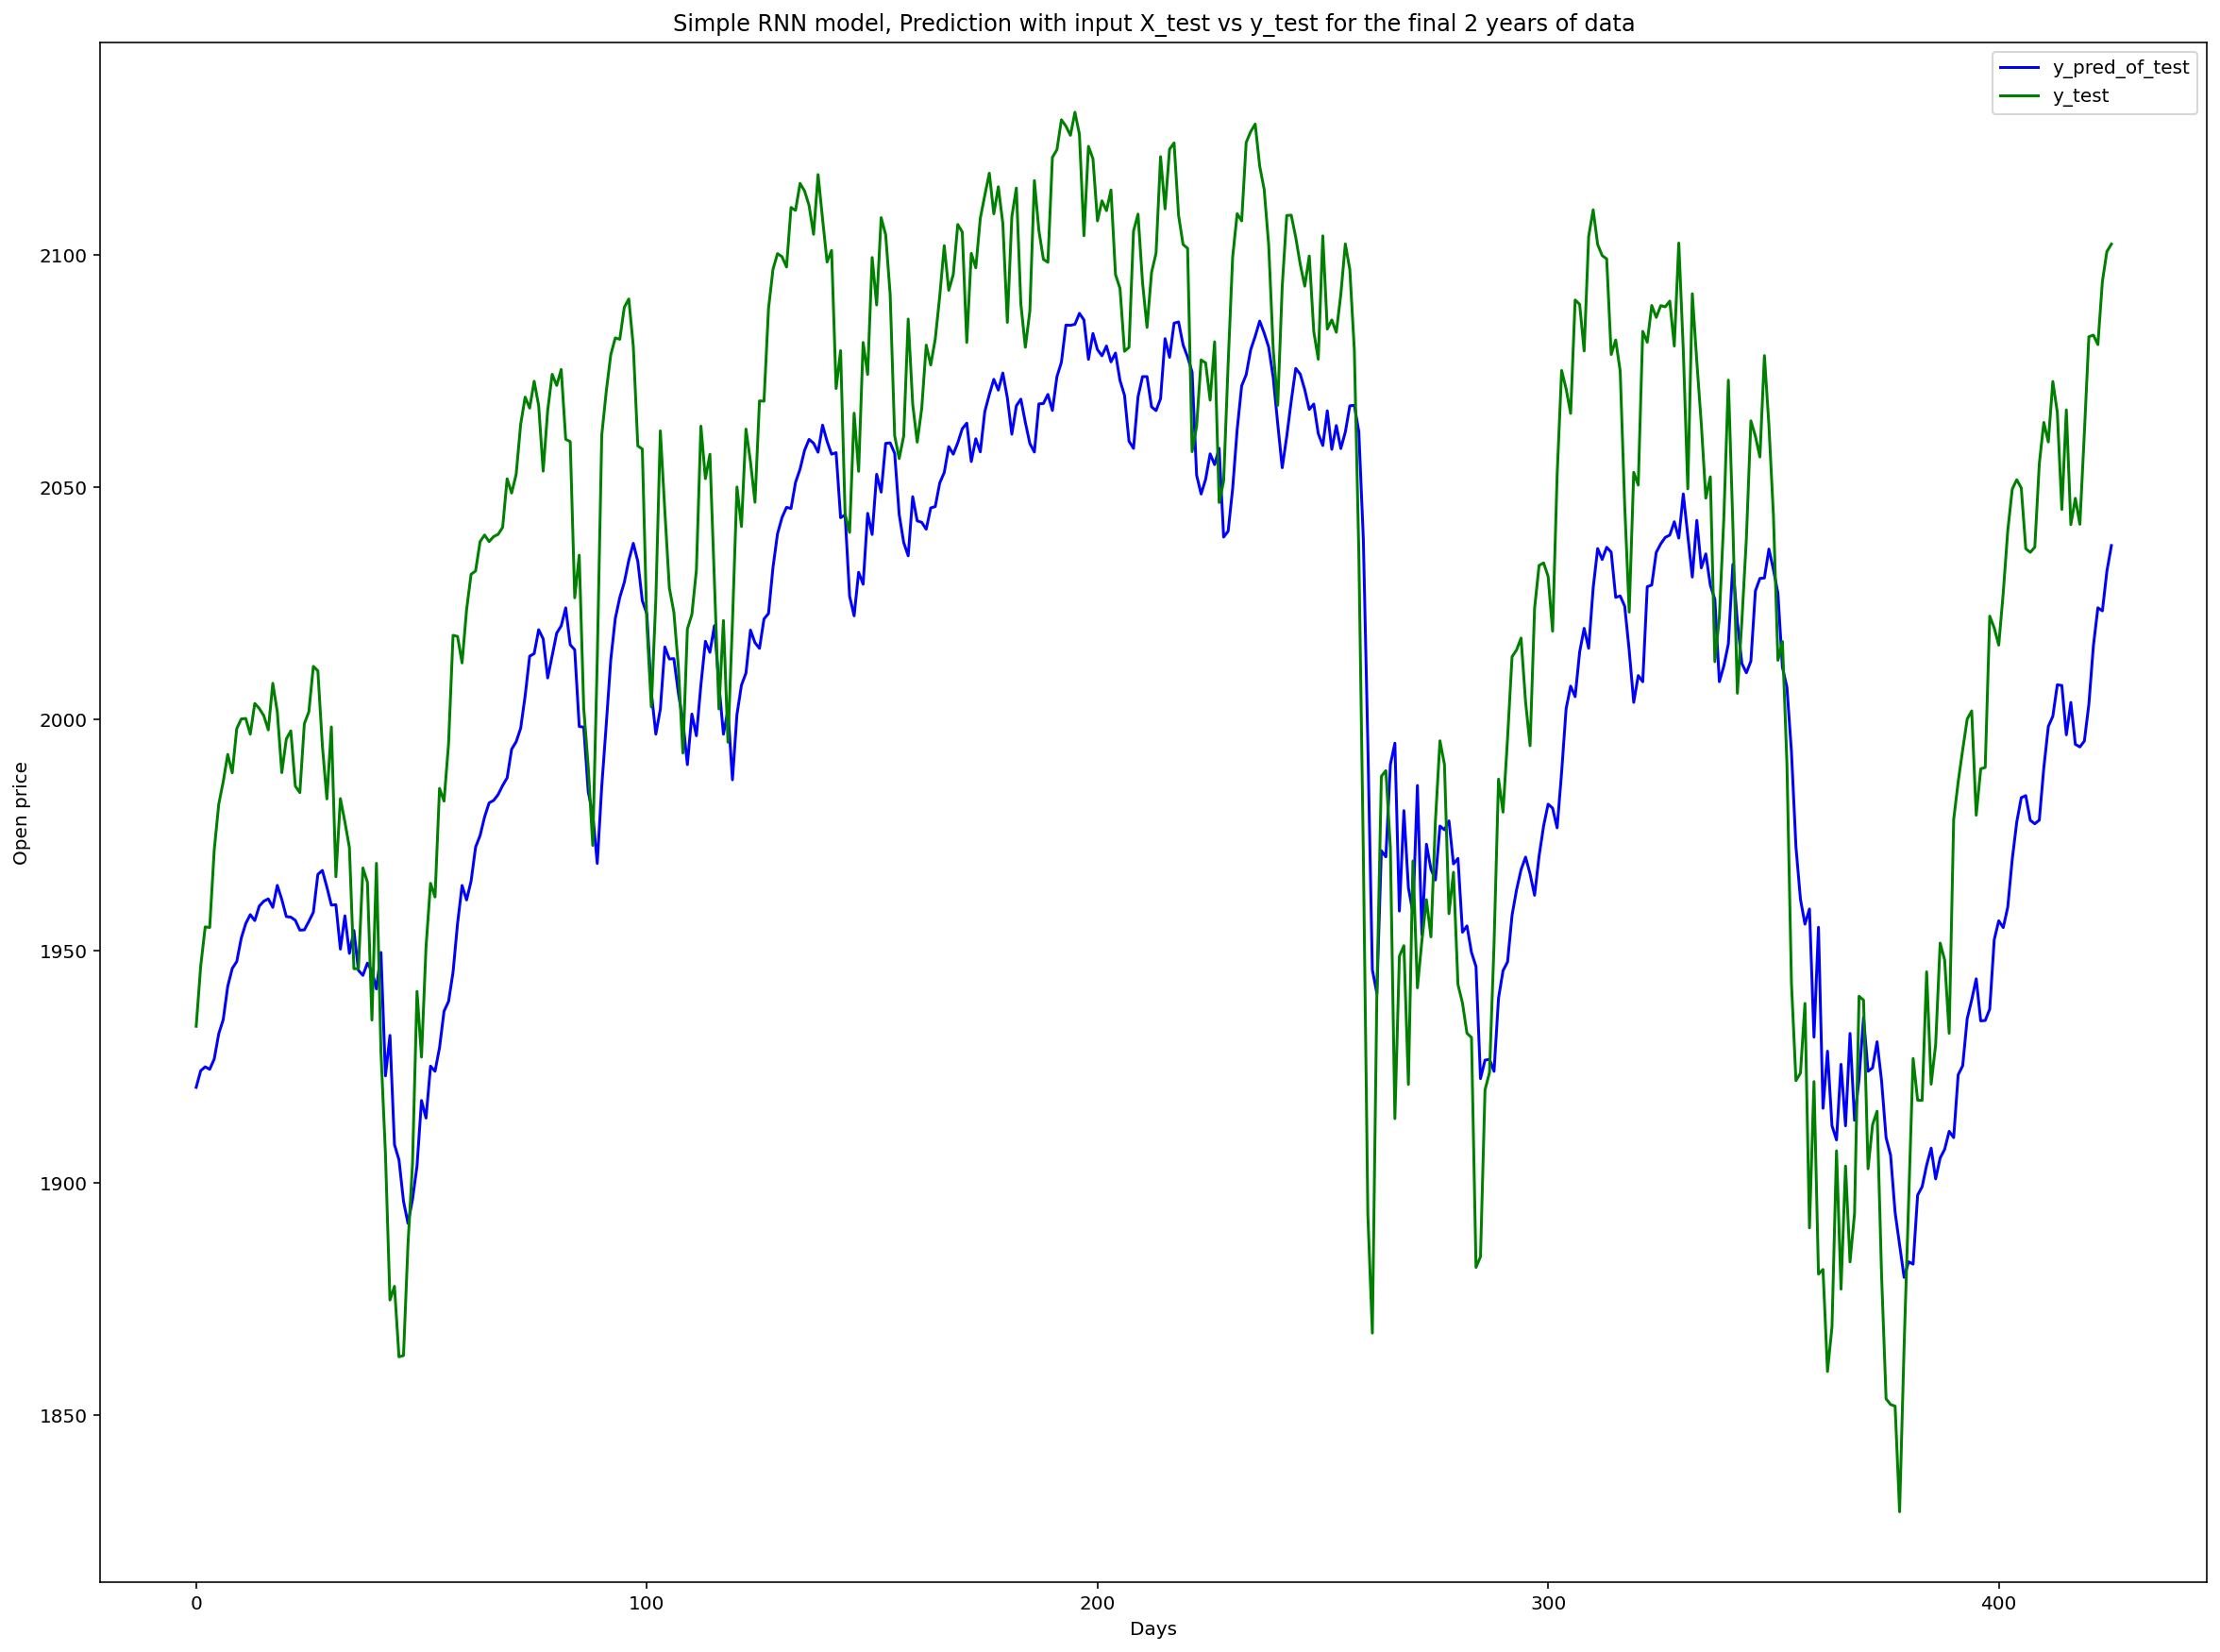

In [948]:
plt.figure(figsize = (20,15))
plt.plot(y_pred_on_test[:426], label = "y_pred_of_test", c = "blue")
plt.plot(y_test[:426], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test for the final 2 years of data")
plt.legend()
plt.show()

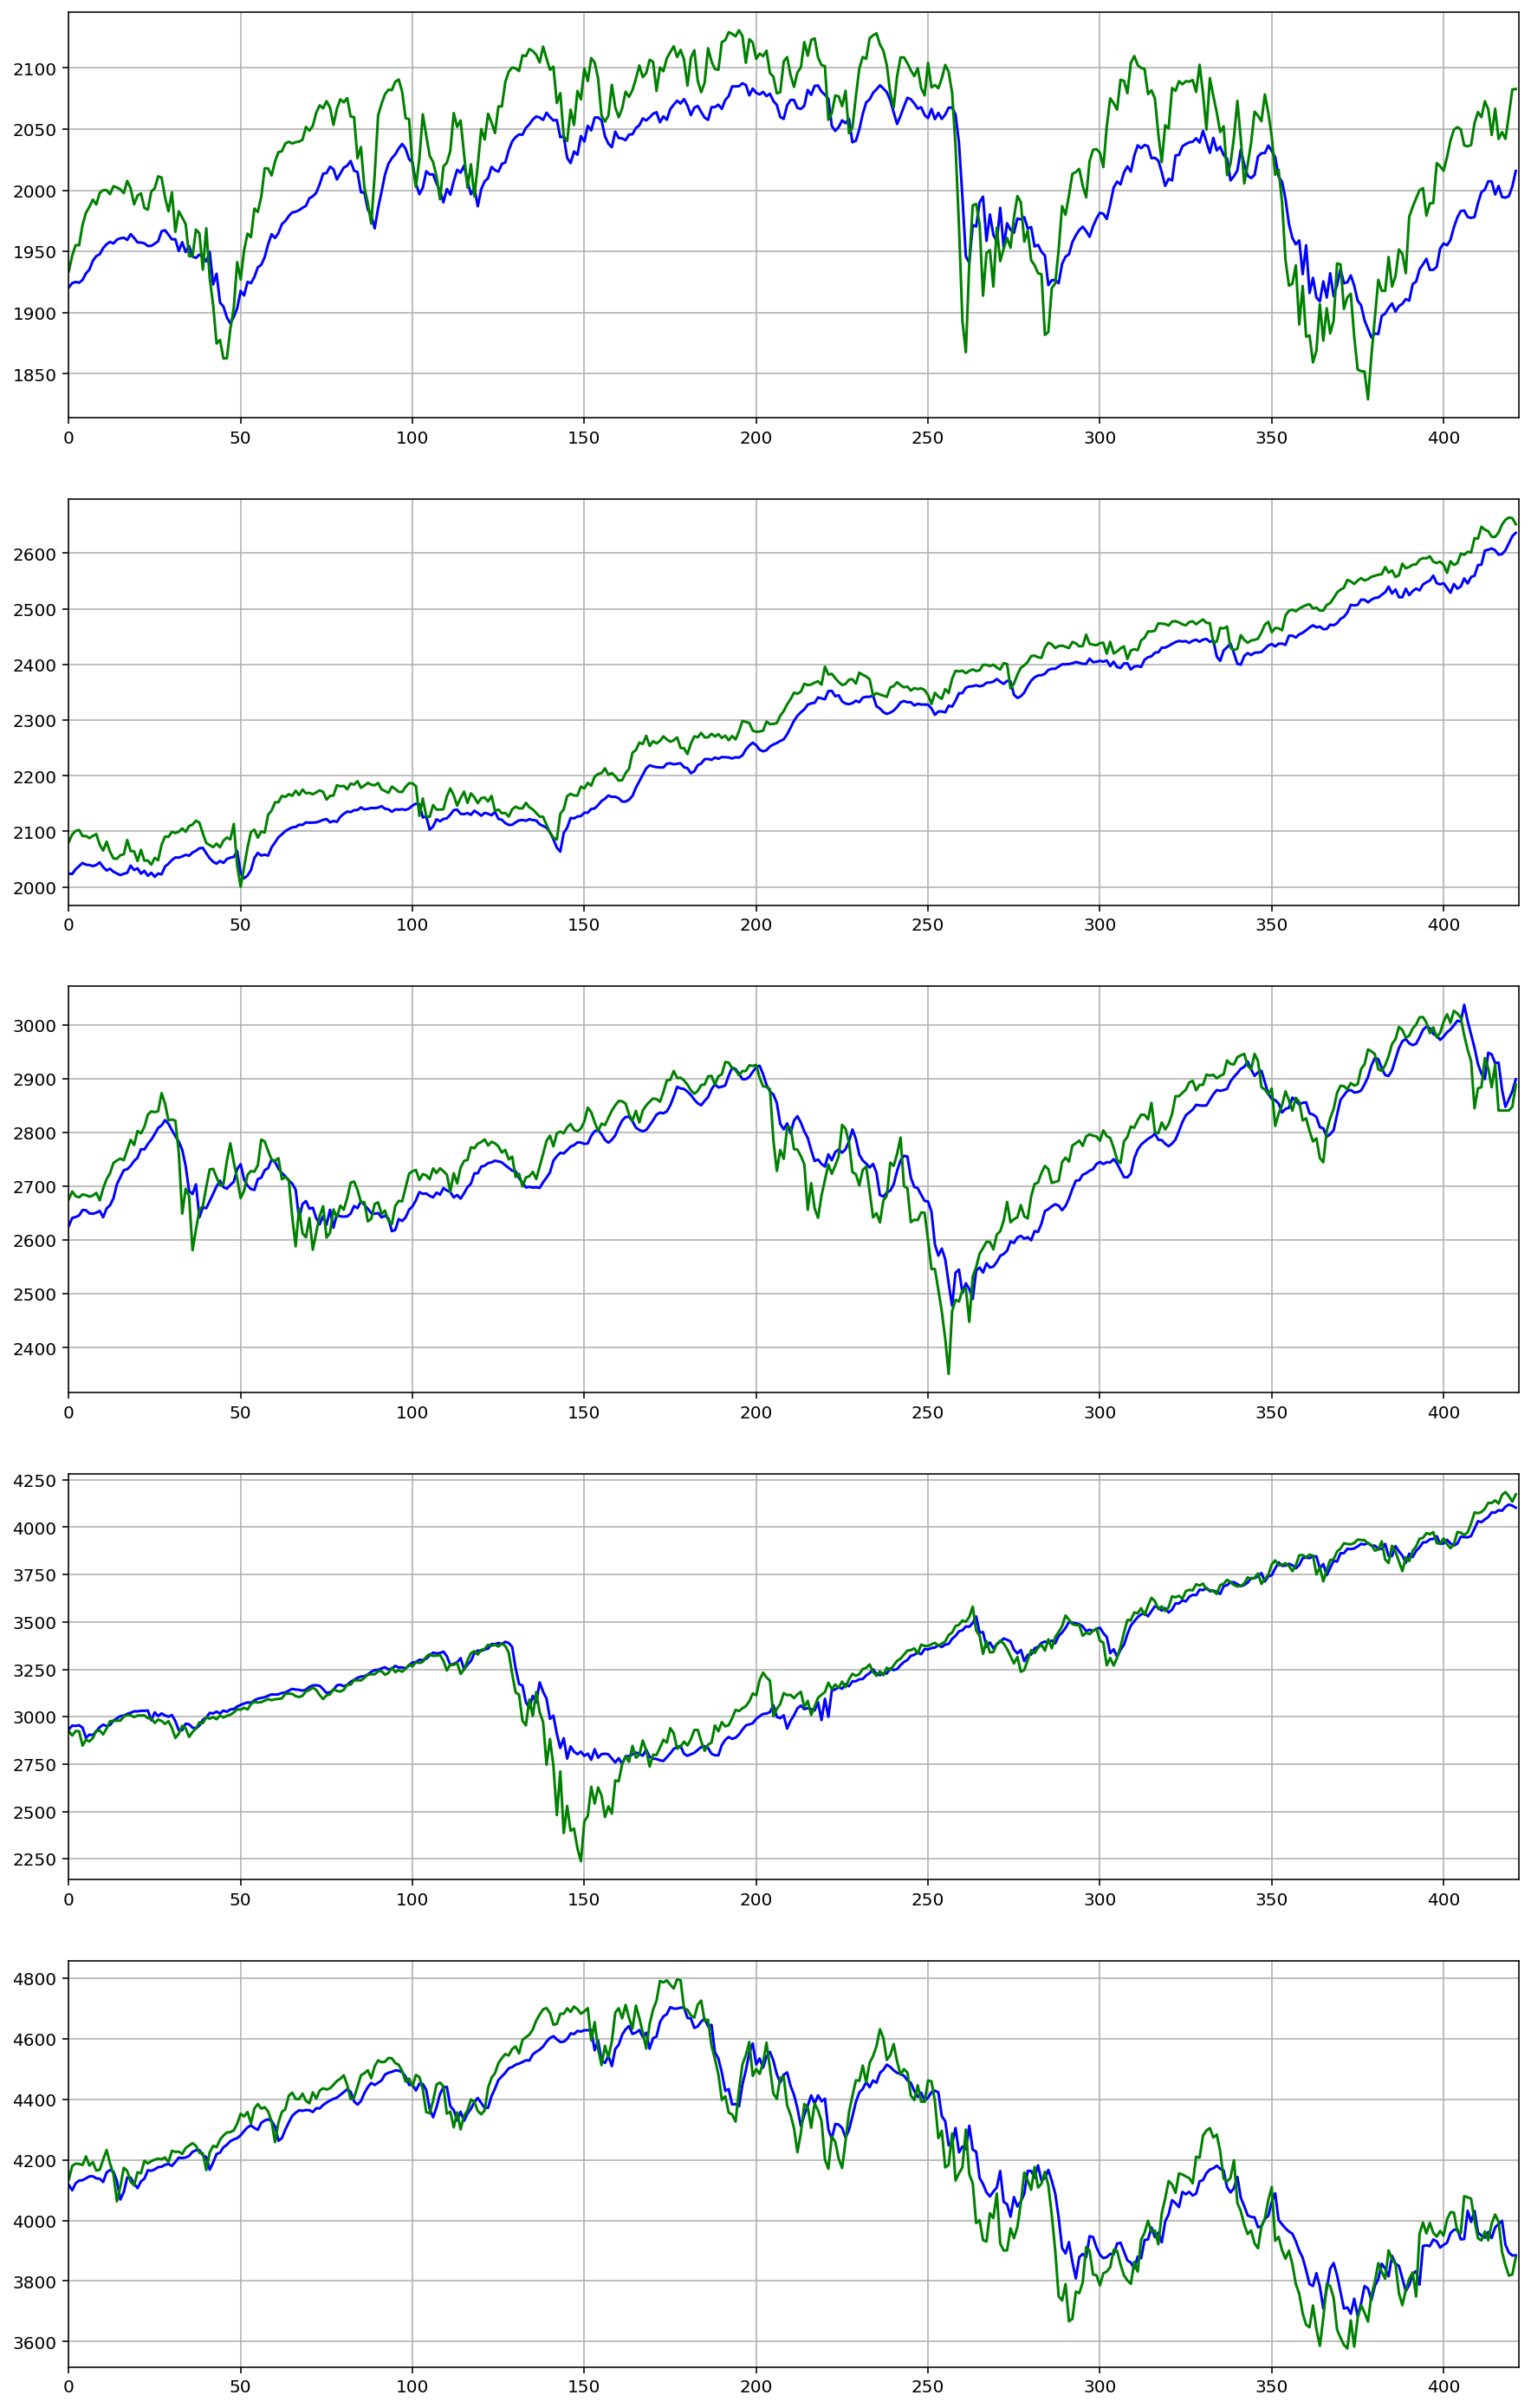

In [949]:
# Create 1 subplot for every "2" years
fig, ax = plt.subplots(5, figsize = (15,25))

for i in range(5):
    ax[i].plot(y_pred_on_test[i * 422: (i + 1) * 422], label = "y_pred_of_test", c = "blue")
    ax[i].plot(y_test[i * 422: (i + 1) * 422], label = "y_test", c = "g")
    ax[i].grid(True)
    ax[i].set_xlim([0,422])

# Strategy 1 with a 30 day time period

In [950]:
# Create DF to compare the actual prices and the predicted prices
df_predicted = pd.DataFrame(y_pred_on_test, columns = ['Predicted Close'])
df_actual = pd.DataFrame(y_test, columns = ['Actual Close'])

In [951]:
df_store = pd.DataFrame.join(df_actual, df_predicted, how = 'left')

In [952]:
df_from_pred = df[['open']][8689:]
df_from_pred = df_from_pred.reset_index()

In [953]:
df_from_pred = df_from_pred.drop('Date', axis=1)
df_store = pd.merge(df_store, df_from_pred, left_index = True, right_index = True)

In [954]:
df_store

Actual Close  Predicted Close     open
0          1933.75      1920.590041  2000.73
1          1946.72      1924.174521  1988.41
2          1955.18      1925.009582  1992.85
3          1955.06      1924.483955  1996.74
4          1971.74      1926.691863  1986.04
...            ...              ...      ...
2105       3895.75      3998.731669  3960.60
2106       3852.36      3919.646819  3999.28
2107       3817.66      3893.780697  4002.25
2108       3821.62      3884.168518  3911.84
2109       3878.44      3884.775229  3909.04

[2110 rows x 3 columns]

In [955]:
# We shift down by one, as our "buy" signal is when the predicted close for the next day, is higher than the current
df_store['Predicted Close'] = df_store['Predicted Close'].shift(-1)
df_store.rename(columns = {'Predicted Close': 'Predicted Close d+1'}, inplace = True)

In [956]:
df_store = df_store.dropna()

In [957]:
df_store.head()

Actual Close  Predicted Close d+1     open
0       1933.75          1924.174521  2000.73
1       1946.72          1925.009582  1988.41
2       1955.18          1924.483955  1992.85
3       1955.06          1926.691863  1996.74
4       1971.74          1932.121479  1986.04

In [958]:
# Create an empty column to store the signal
df_store['signal'] = np.nan

# Sets the signal, if the prediction for the next day is greater than the current close, then assign 1.
for i in range(len(df_store)):
    if (df_store.iloc[i][1] - df_store.iloc[i][2]) >= 0:
        df_store['signal'].iloc[i] = 1
    else:
        df_store['signal'].iloc[i] = -1

/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_12239/3547608008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['signal'] = np.nan
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_12239/3547608008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store['signal'].iloc[i] = -1
/var/folders/yg/069hjm3s3h93pz6xvwym8qxr0000gn/T/ipykernel_12239/3547608008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [959]:
# Create a copy table
df_results = df_store.copy()

#Create empty col

df_results['strat returns'] = np.nan
df_results['strat returns'].iloc[0] = 0

for i in range(1, len(df_store)-1):
    if df_results['signal'].iloc[i] > 0:
        # In this run through we will use the open value 
        df_results['strat returns'].iloc[i] = df_results['Actual Close'].iloc[i] - df_results['open'].iloc[i]
    elif df_results['signal'].iloc[i] < 0:
        df_results['strat returns'].iloc[i] = 0
#     df_results['investment'].iloc[i] = df_results['investment'].iloc[i-1] * (1 + (df_results['p/l'].iloc[i] / df_results['Actual Close'].iloc[i - 1]))

In [960]:
df_results['return'] = df_results['Actual Close'] - df_results['Actual Close'].shift(1)

In [961]:
df_results.head()

Actual Close  Predicted Close d+1     open  signal  strat returns  return
0       1933.75          1924.174521  2000.73    -1.0            0.0     NaN
1       1946.72          1925.009582  1988.41    -1.0            0.0   12.97
2       1955.18          1924.483955  1992.85    -1.0            0.0    8.46
3       1955.06          1926.691863  1996.74    -1.0            0.0   -0.12
4       1971.74          1932.121479  1986.04    -1.0            0.0   16.68

In [962]:
df_results['strat relative change'] = (df_results['strat returns'] / df_results['Actual Close'])
df_results['buy hold relative change'] = (df_results['return'] / df_results['Actual Close'].shift(1))

In [963]:
df_results['return'].iloc[0] = 0
df_results.dropna()

Actual Close  Predicted Close d+1     open  signal  strat returns  \
1          1946.72          1925.009582  1988.41    -1.0           0.00   
2          1955.18          1924.483955  1992.85    -1.0           0.00   
3          1955.06          1926.691863  1996.74    -1.0           0.00   
4          1971.74          1932.121479  1986.04    -1.0           0.00   
5          1981.60          1935.205824  1981.93    -1.0           0.00   
...            ...                  ...      ...     ...            ...   
2103       4019.65          3988.010879  3932.35     1.0          87.30   
2104       3995.32          3998.731669  3977.57     1.0          17.75   
2105       3895.75          3919.646819  3960.60    -1.0           0.00   
2106       3852.36          3893.780697  3999.28    -1.0           0.00   
2107       3817.66          3884.168518  4002.25    -1.0           0.00   

      return  strat relative change  buy hold relative change  
1      12.97               0.000000                  0.006707  
2       8.46               0.000000                  0.004346  
3      -0.12               0.000000                 -0.000061  
4      16.68               0.000000                  0.008532  
5       9.86               0.000000                  0.005001  
...      ...                    ...                       ...  
2103   29.09               0.021718                  0.007290  
2104  -24.33               0.004443                 -0.006053  
2105  -99.57               0.000000                 -0.024922  
2106  -43.39               0.000000                 -0.011138  
2107  -34.70               0.000000                 -0.009007  

[2107 rows x 8 columns]

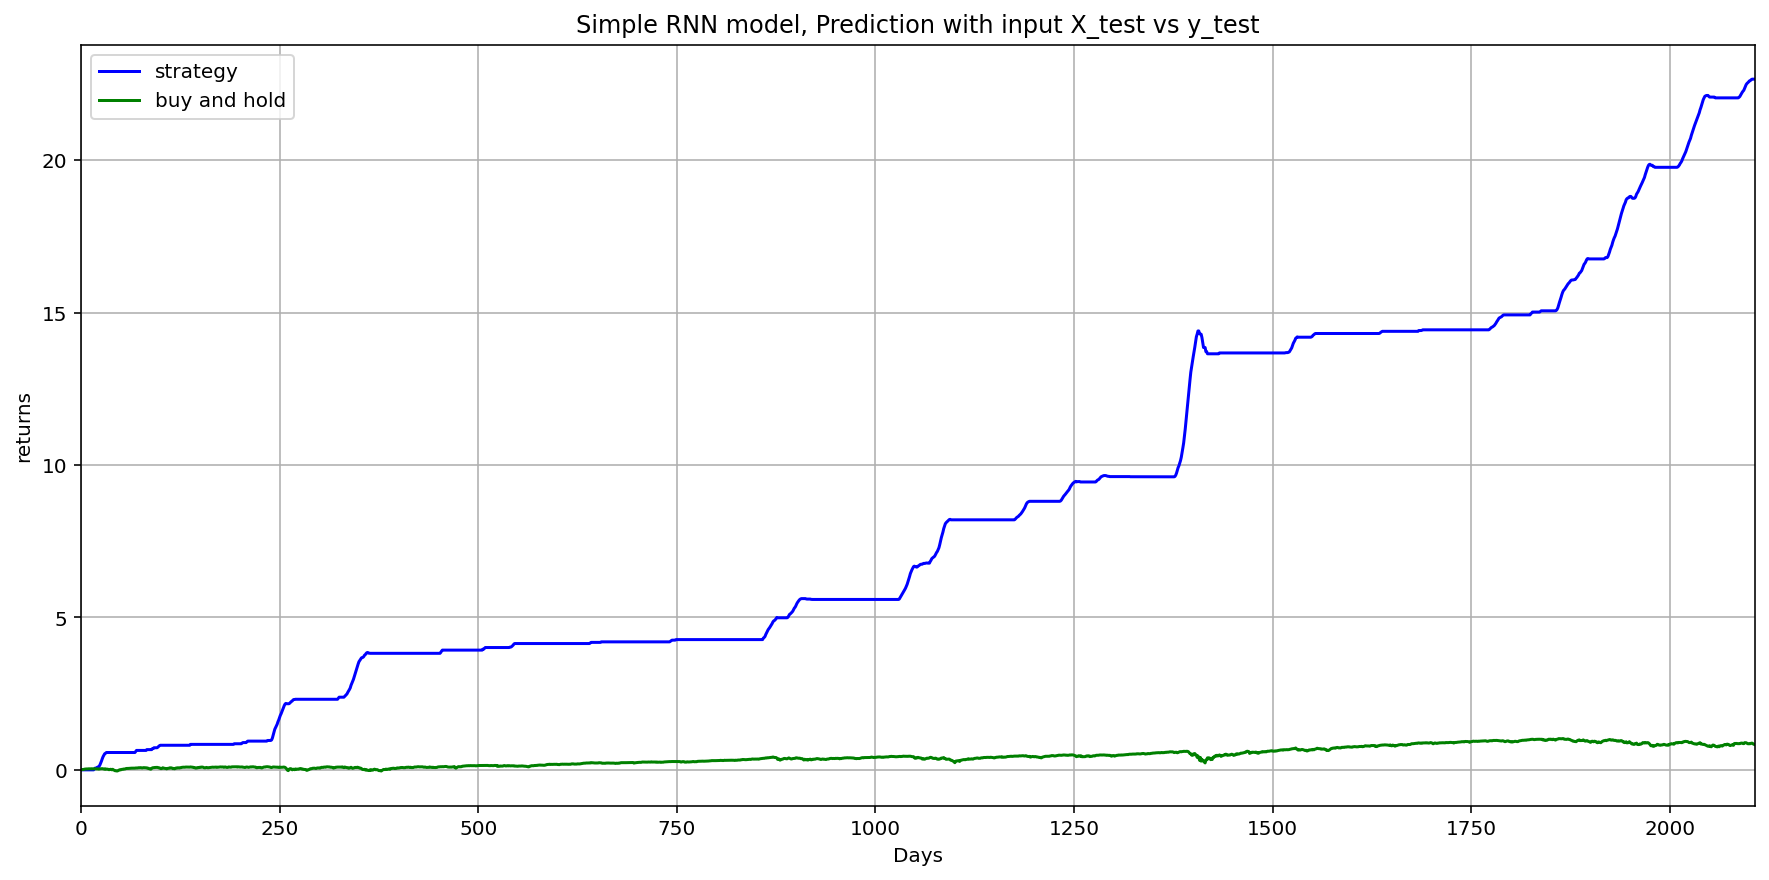

In [964]:
plt.figure(figsize = (15, 7))
plt.plot(df_results['strat relative change'].cumsum(), label = 'strategy', c = "blue")
plt.plot(df_results['buy hold relative change'].cumsum(), label = "buy and hold", c = "g")
plt.xlabel("Days")
plt.ylabel("returns")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend(loc = 'upper left')
plt.grid(True)
plt.xlim([0,2107])
plt.show()

In [965]:
print('10 year return applying strategy:', 1 + df_results['strat relative change'].sum())
print('10 year return buy and hold:', 1 + df_results['buy hold relative change'].sum())

10 year return applying strategy: 23.654030338550342
10 year return buy and hold: 1.826558764447888


In [966]:
# Invest 100,000 ~ 10 years ago
print(100000 * (1 + df_results['strat relative change'].sum()))
print(100000 * (1 + df_results['buy hold relative change'].sum()))

2365403.033855034
182655.8764447888


In [968]:
df_results['strat relative change'].sum() / df_results['buy hold relative change'].sum()

27.40764639242853

In [969]:
df_results.to_csv('output30day.csv')

# Prediction modelling again but altering the parameters

I noticed that the learning rate may have been too high as there are a lot of jumps while the model is training, so we are going to decrease the learning rate, and decrease the neurons per layers and add more neurons, and return the recurrent days to 50

In [363]:
# Create the training data
X_train, y_train = [], []

time_step = 50

length_train = 8639 # length data * 0.8

# This step is necessary to pass into a RNN
for i in range(time_step, length_train):
    X_train.append(training_scaled[i - time_step : i, :])
    y_train.append(training_scaled[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [364]:
# Creating the test data
X_test, y_test = [], []

length_train = test_data.shape[0]

for i in range(time_step, length_train):
    X_test.append(testing_scaled[i - time_step : i, :])
    y_test.append(testing_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [365]:
print(X_train.shape)
print(y_train.shape)

(8589, 50, 13)
(8589,)


In [366]:
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (-1,1))

In [358]:
model = Sequential([
    SimpleRNN(55, return_sequences = True),
    SimpleRNN(55, return_sequences = True),
    SimpleRNN(55, return_sequences = True),
    SimpleRNN(55, return_sequences = True),
    SimpleRNN(55, return_sequences = True),
    SimpleRNN(55),
    Dense(1)
])

In [361]:
# Define some model parameters
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [369]:
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [370]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
269/269 [==============================] - 10s 26ms/step - loss: 0.0032 - mean_absolute_error: 0.0378
Epoch 2/100
269/269 [==============================] - 7s 26ms/step - loss: 0.0026 - mean_absolute_error: 0.0348
Epoch 3/100
269/269 [==============================] - 8s 28ms/step - loss: 0.0023 - mean_absolute_error: 0.0331
Epoch 4/100
269/269 [==============================] - 7s 26ms/step - loss: 0.0019 - mean_absolute_error: 0.0300
Epoch 5/100
269/269 [==============================] - 7s 26ms/step - loss: 0.0017 - mean_absolute_error: 0.0284
Epoch 6/100
269/269 [==============================] - 7s 27ms/step - loss: 0.0015 - mean_absolute_error: 0.0269
Epoch 7/100
269/269 [==============================] - 7s 26ms/step - loss: 0.0014 - mean_absolute_error: 0.0264
Epoch 8/100
269/269 [==============================] - 7s 27ms/step - loss: 0.0013 - mean_absolute_error: 0.0262
Epoch 9/100
269/269 [==============================] - 7s 26ms/step - loss: 0.0012 - mean_absol

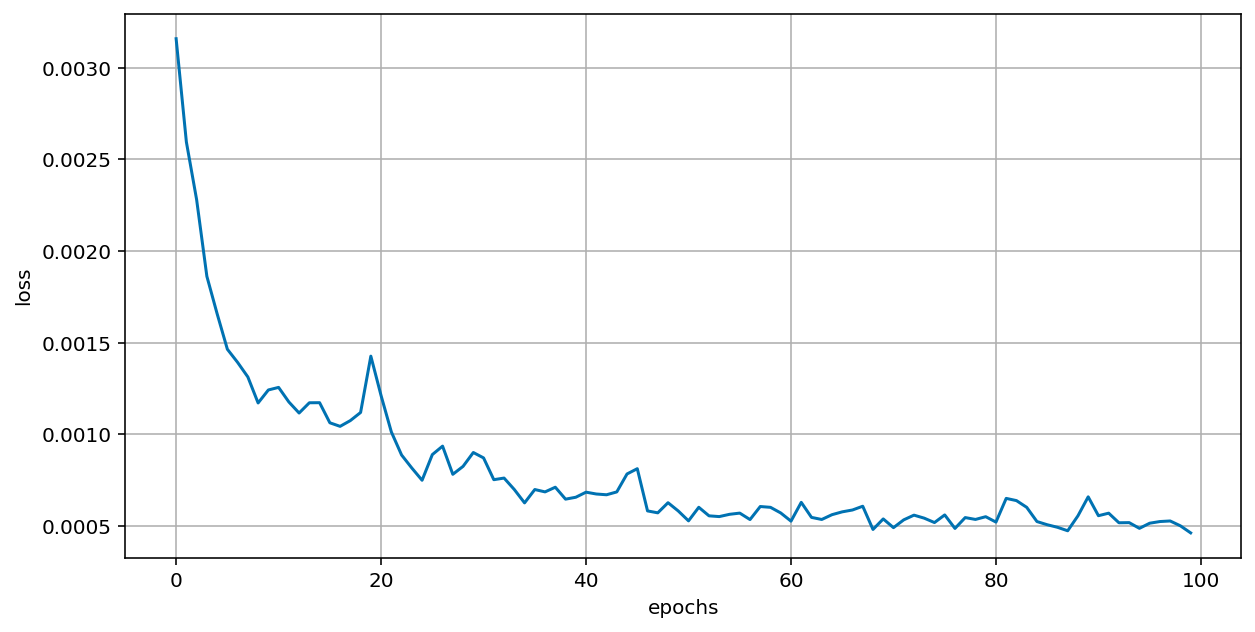

In [371]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [372]:
model.evaluate(X_test, y_test)

66/66 [==============================] - 1s 9ms/step - loss: 0.0065 - mean_absolute_error: 0.0488


[0.0064726220443844795, 0.048770610243082047]

In [373]:
y_pred = model.predict(X_train)

# Unscale the predicted values
# create empty table with 13 fields (same number of columns)
y_pred_dataset_like = np.zeros(shape=(len(y_pred), 13) )

# put the predicted values in the right field
y_pred_dataset_like[:,0] = y_pred[:,0]
# inverse transform and then select the right field
y_pred = scaler.inverse_transform(y_pred_dataset_like)[:,0]

y_pred = np.reshape(y_pred, (y_pred.shape[0],1))

print(y_pred.shape)

269/269 [==============================] - 3s 9ms/step
(8589, 1)


In [374]:
# Unscaled the training set values
# create empty table with 13 fields
y_train_dataset_like = np.zeros(shape=(len(y_train), 13) )

# put the predicted values in the right field
y_train_dataset_like[:,0] = y_train[:,0]
# inverse transform and then select the right field
y_train = scaler.inverse_transform(y_train_dataset_like)[:,0]

y_train = np.reshape(y_train, (y_train.shape[0],1))

print(y_train.shape)

(8589, 1)


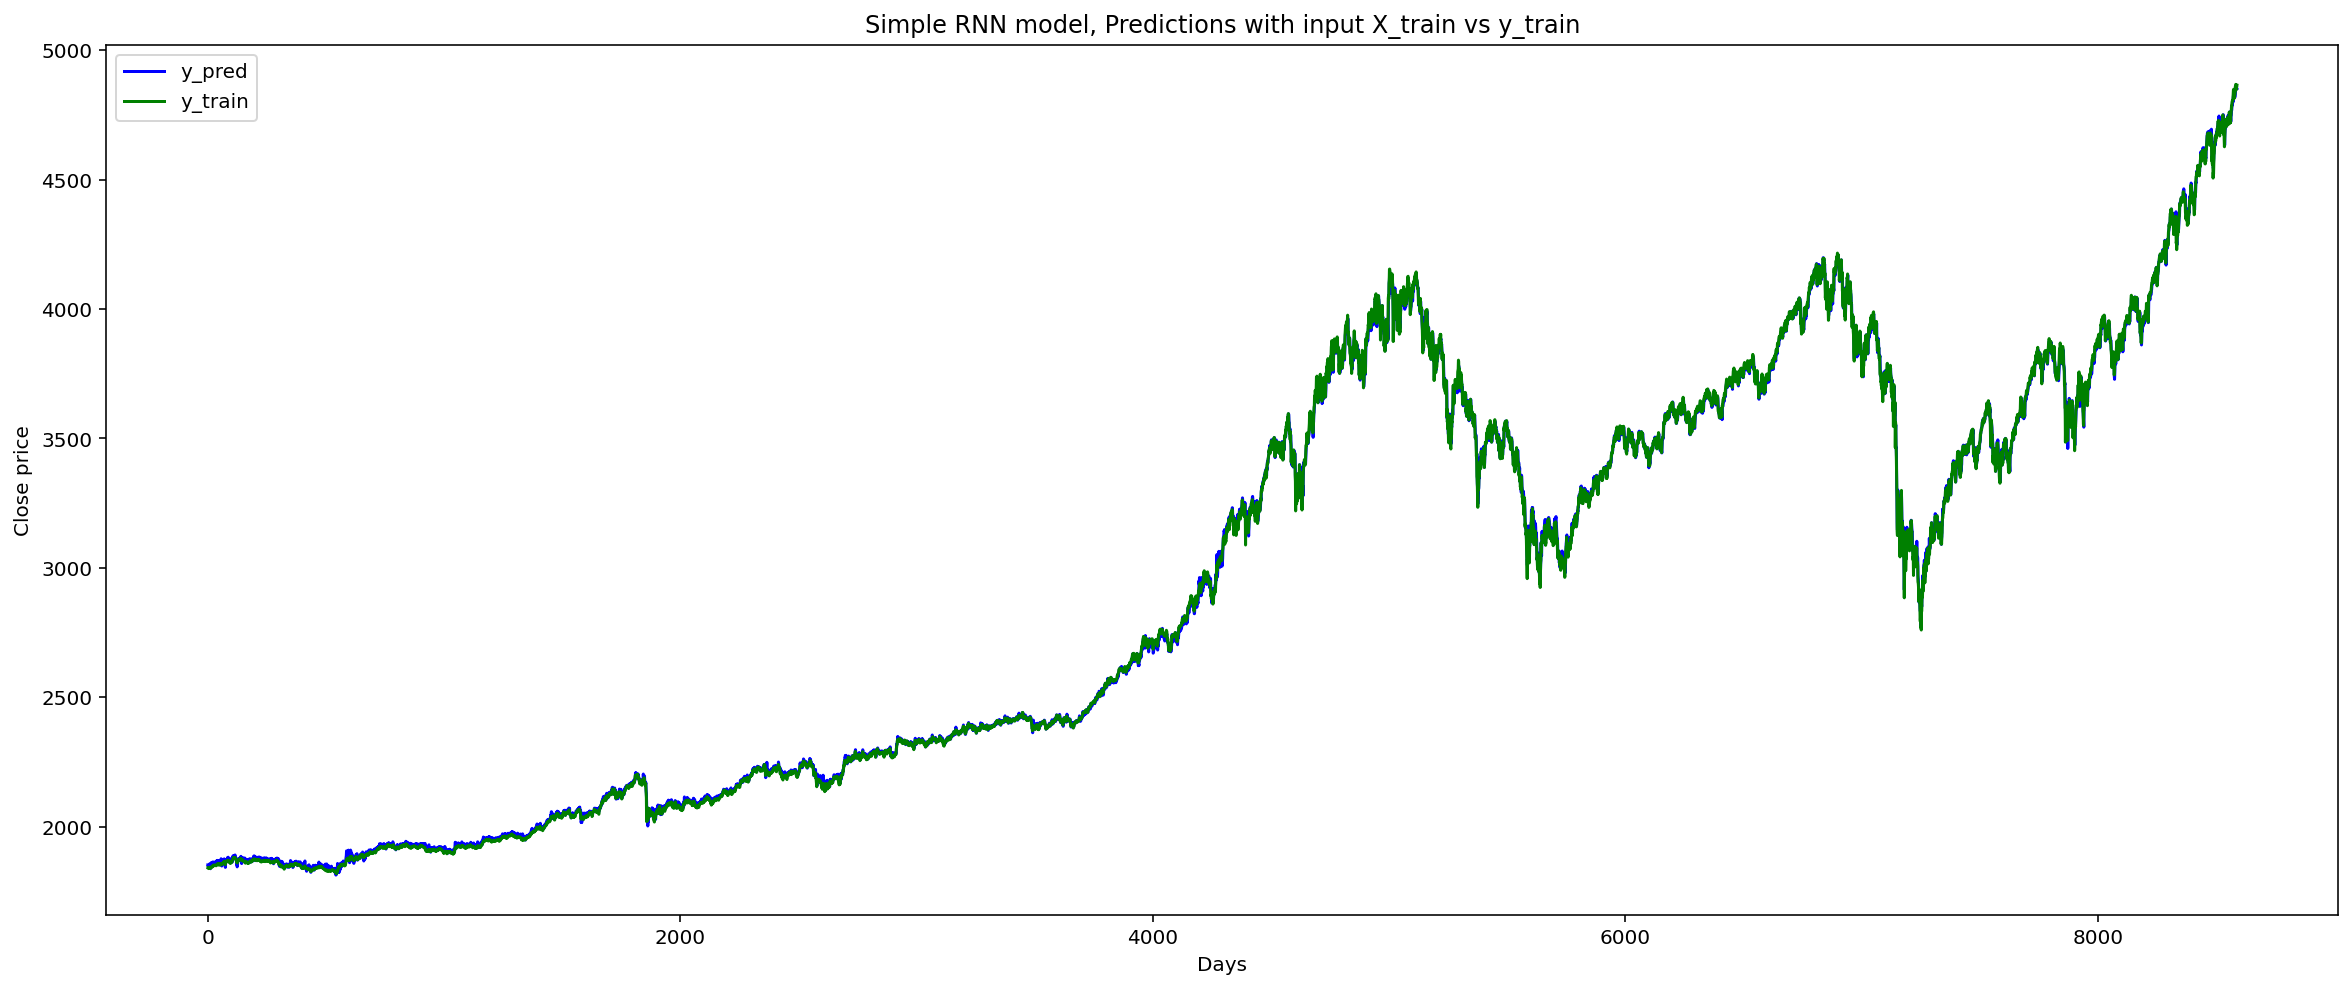

In [375]:
plt.figure(figsize = (20,8))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Close price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [376]:
# Make a prediction on the test set
y_pred_on_test = model.predict(X_test)
y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

66/66 [==============================] - 1s 8ms/step


In [377]:
# Unscale these values
# create empty table with 13 fields
y_test_pred_dataset_like = np.zeros(shape=(len(y_pred_on_test), 13))

# put the predicted values in the right field
y_test_pred_dataset_like[:,0] = y_pred_on_test[:,0]
# inverse transform and then select the right field
y_pred_on_test = scaler.inverse_transform(y_test_pred_dataset_like)[:,0]

y_pred_on_test = np.reshape(y_pred_on_test,(-1,1))

print(y_pred_on_test.shape)

(2110, 1)


In [378]:
# create empty table with 13 fields
y_test_dataset_like = np.zeros(shape=(len(y_test), 13))

# put the predicted values in the right field
y_test_dataset_like[:,0] = y_test[:,0]
# inverse transform and then select the right field
y_test = scaler.inverse_transform(y_test_dataset_like)[:,0]

y_test = np.reshape(y_test, (-1,1))

print(y_test.shape)

(2110, 1)


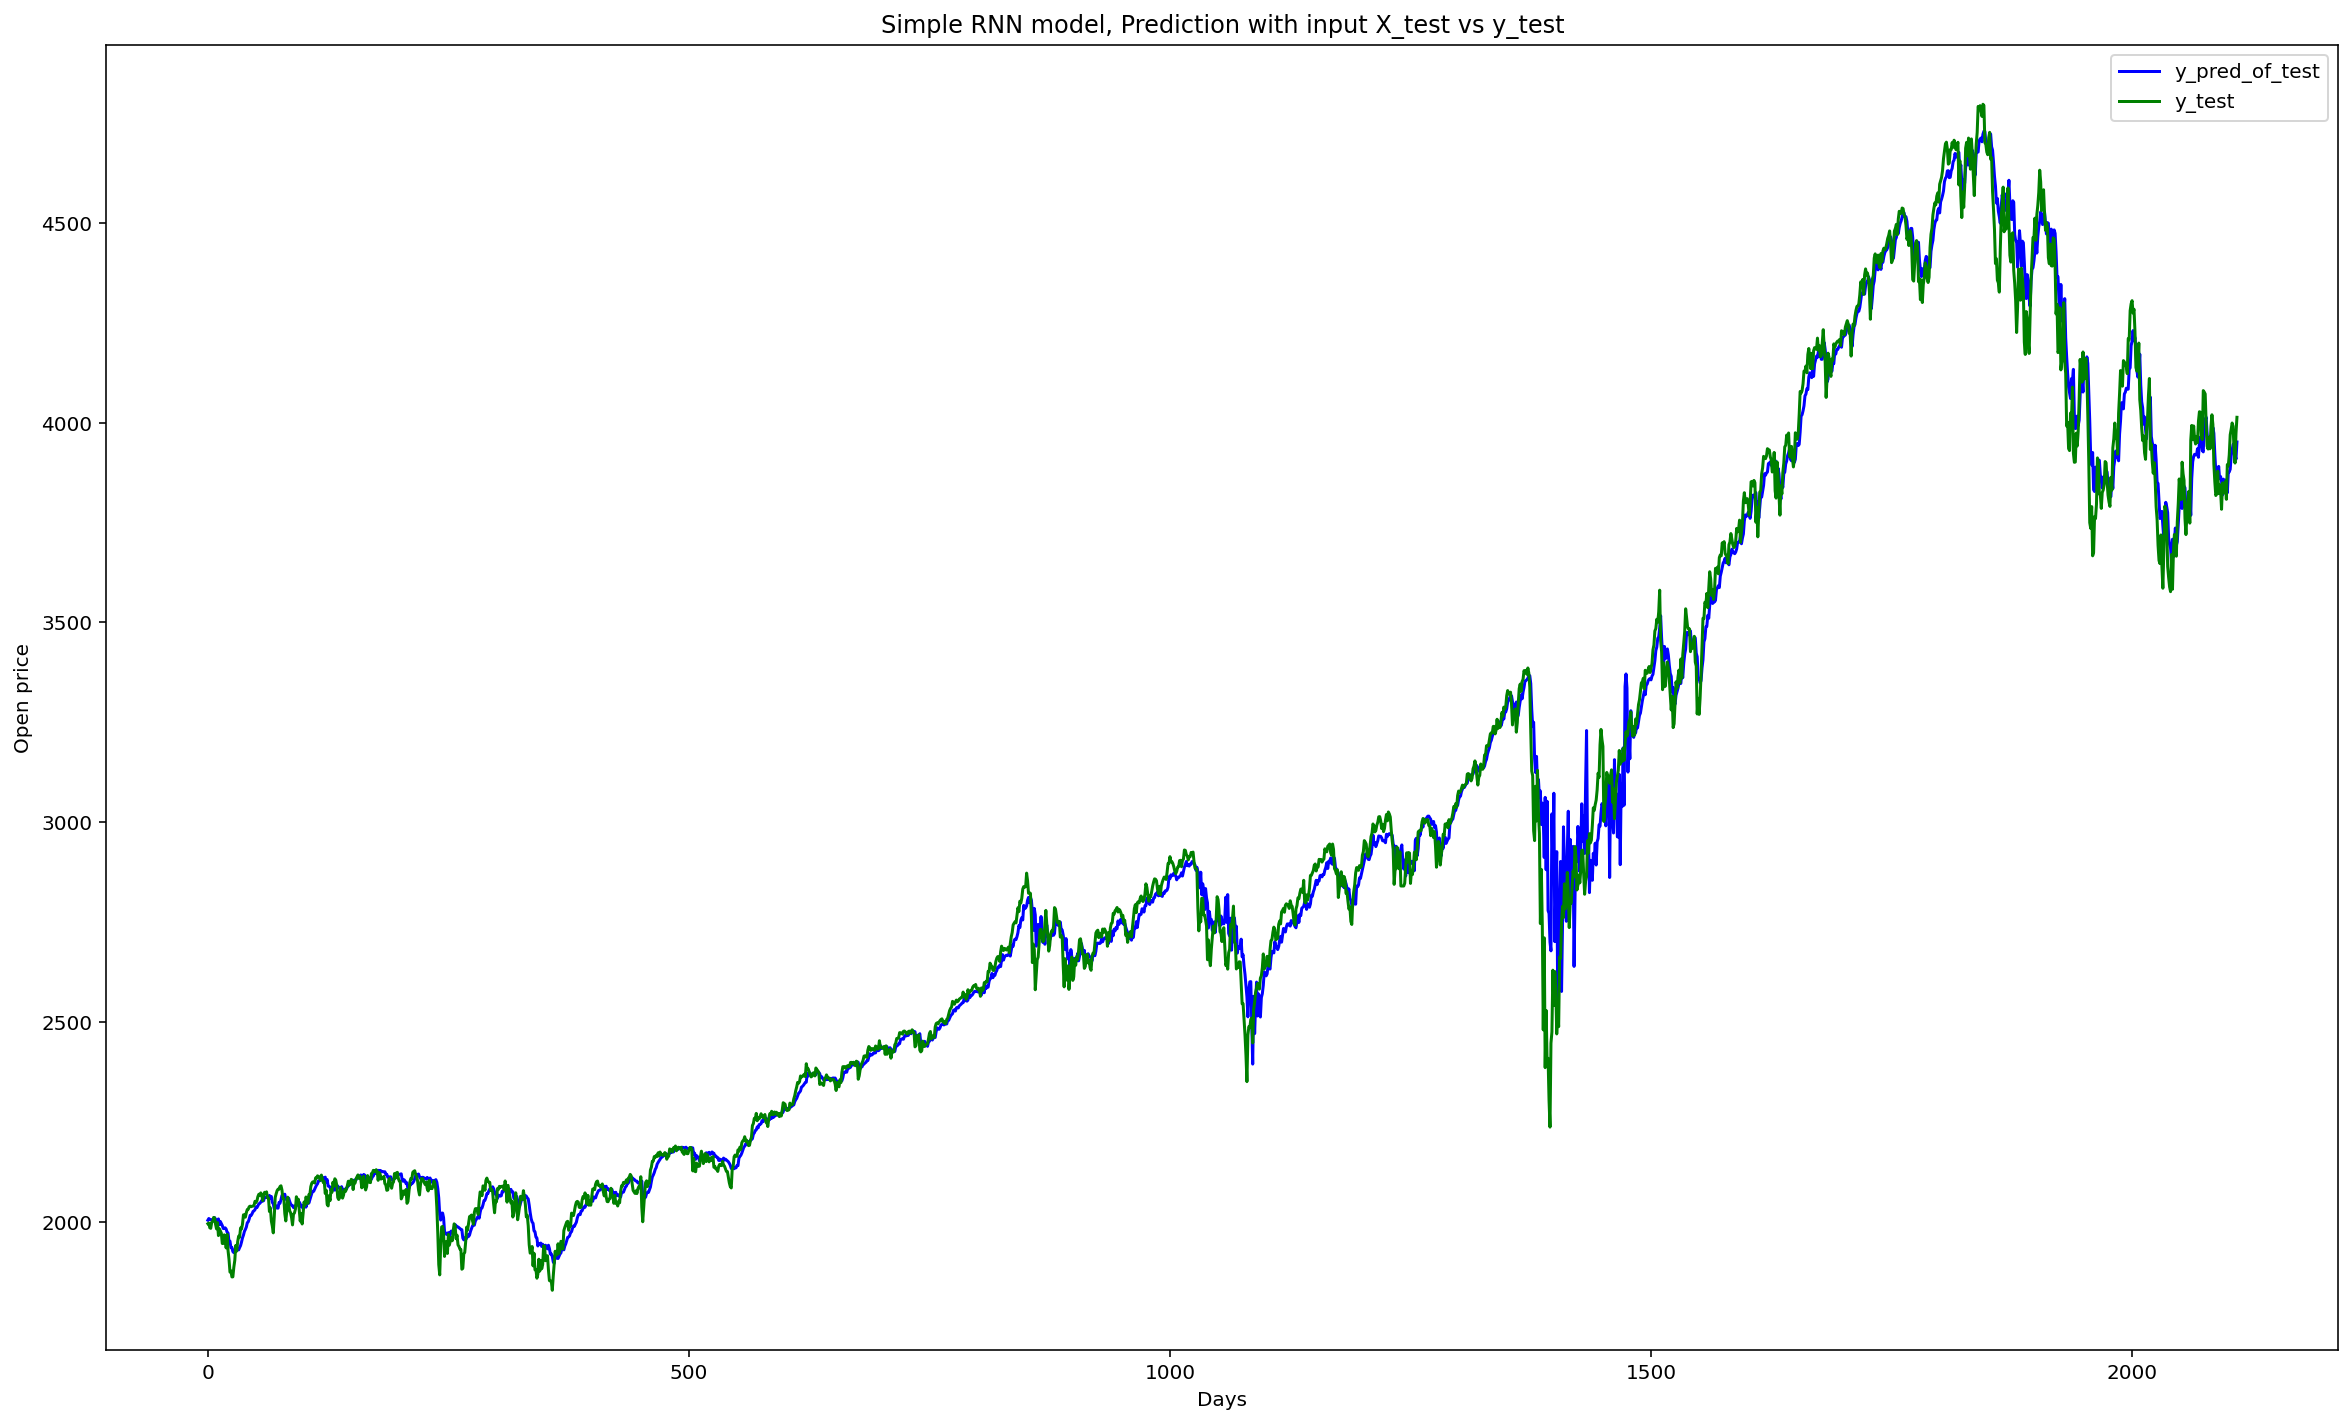

In [380]:
plt.figure(figsize = (20,12))
plt.plot(y_pred_on_test, label = "y_pred_of_test", c = "blue")
plt.plot(y_test, label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

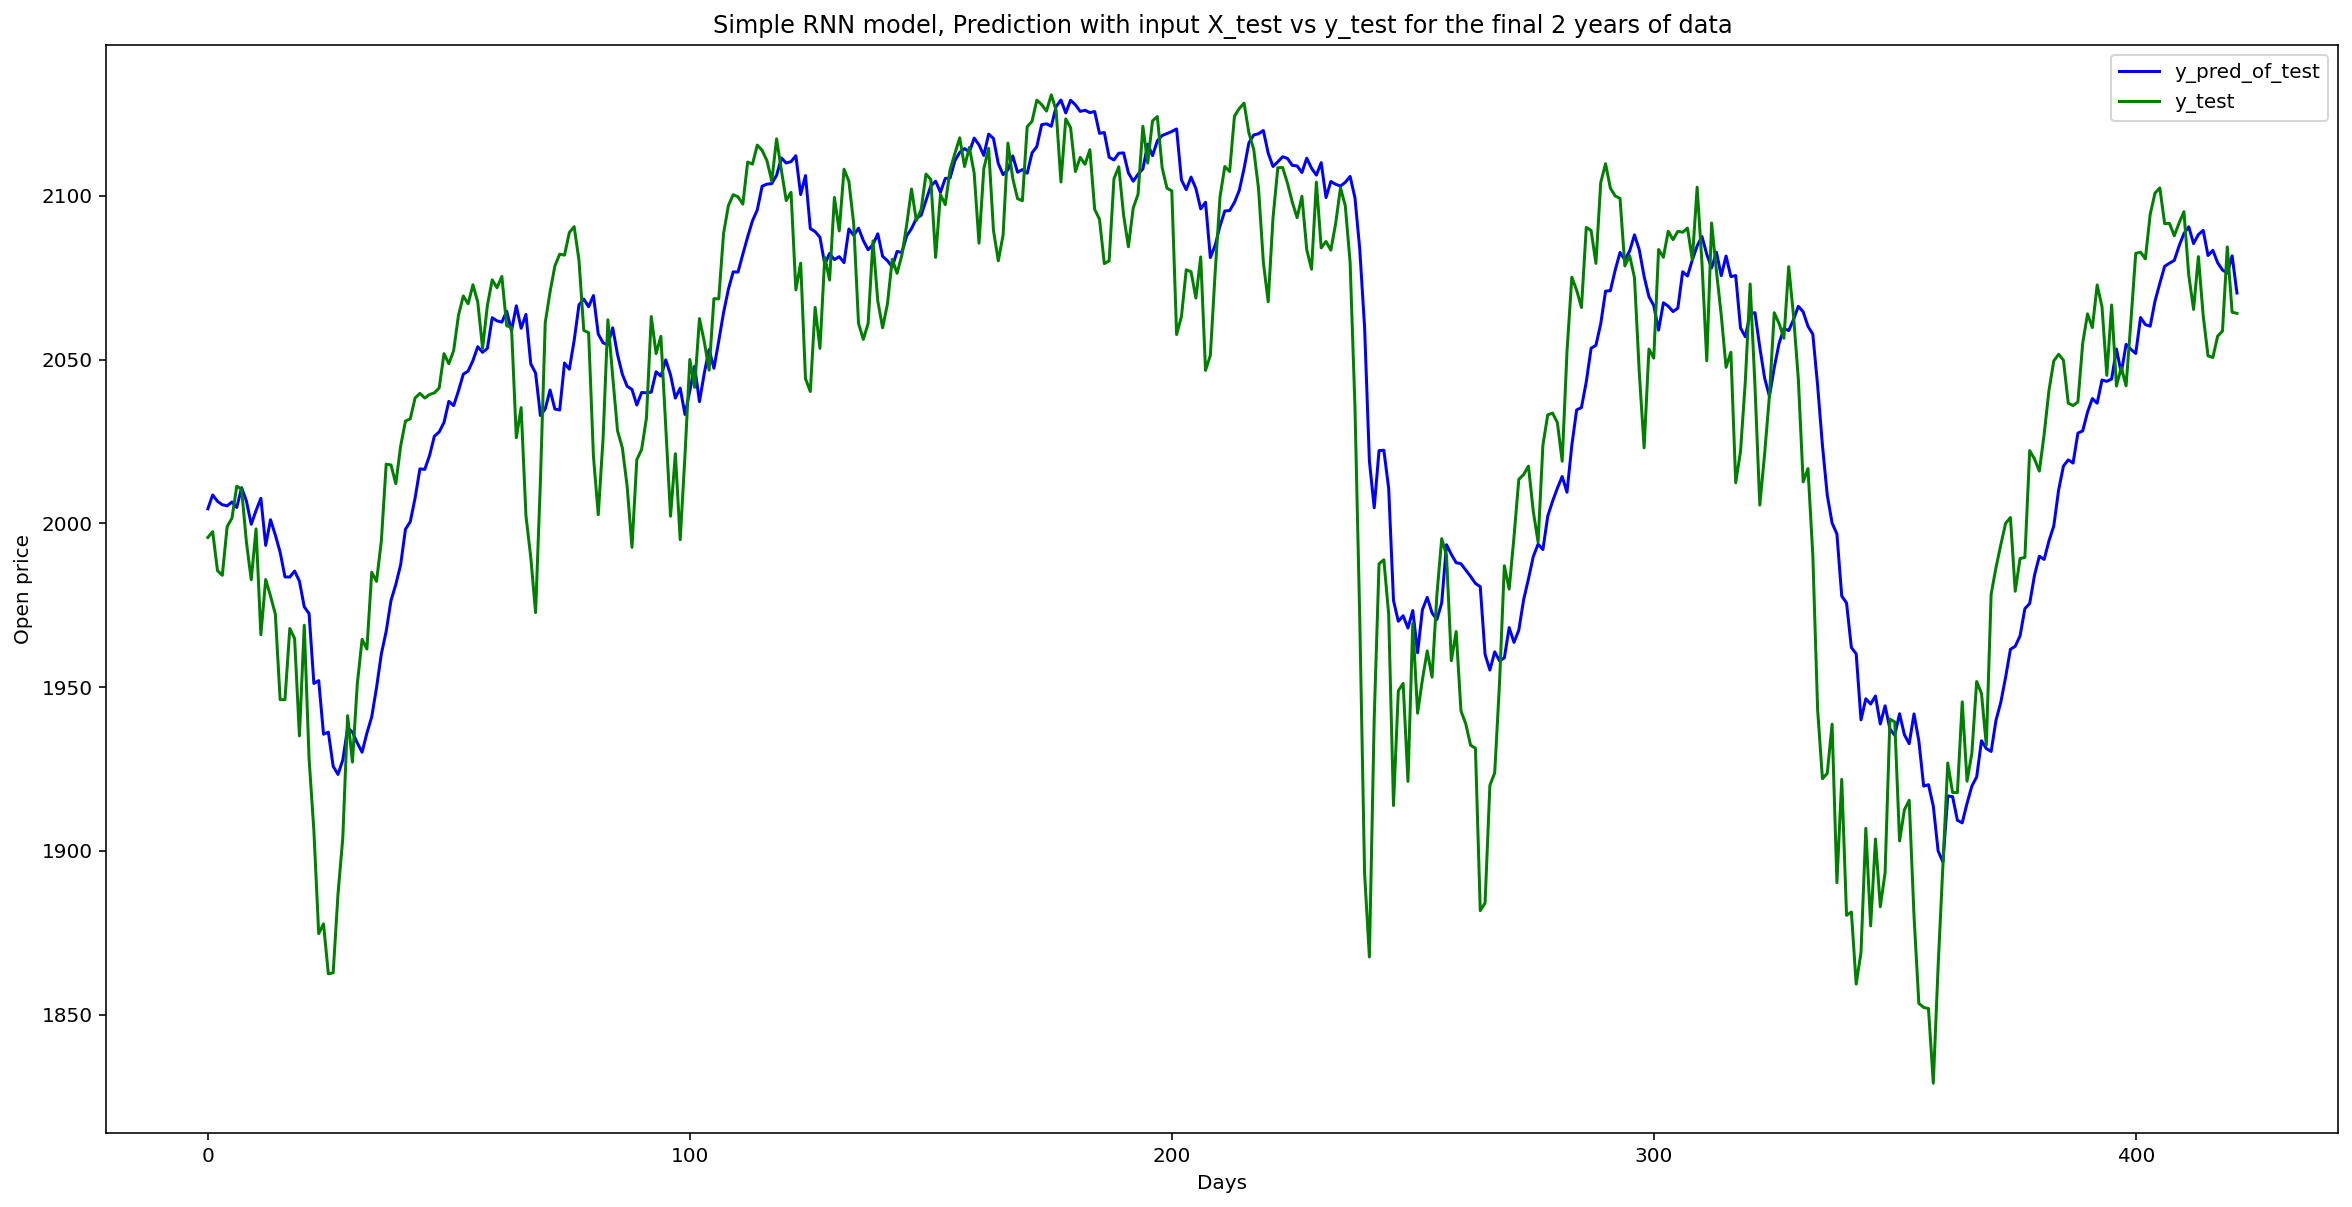

In [382]:
plt.figure(figsize = (20,10))
plt.plot(y_pred_on_test[:422], label = "y_pred_of_test", c = "blue")
plt.plot(y_test[:422], label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test for the final 2 years of data")
plt.legend()
plt.show()

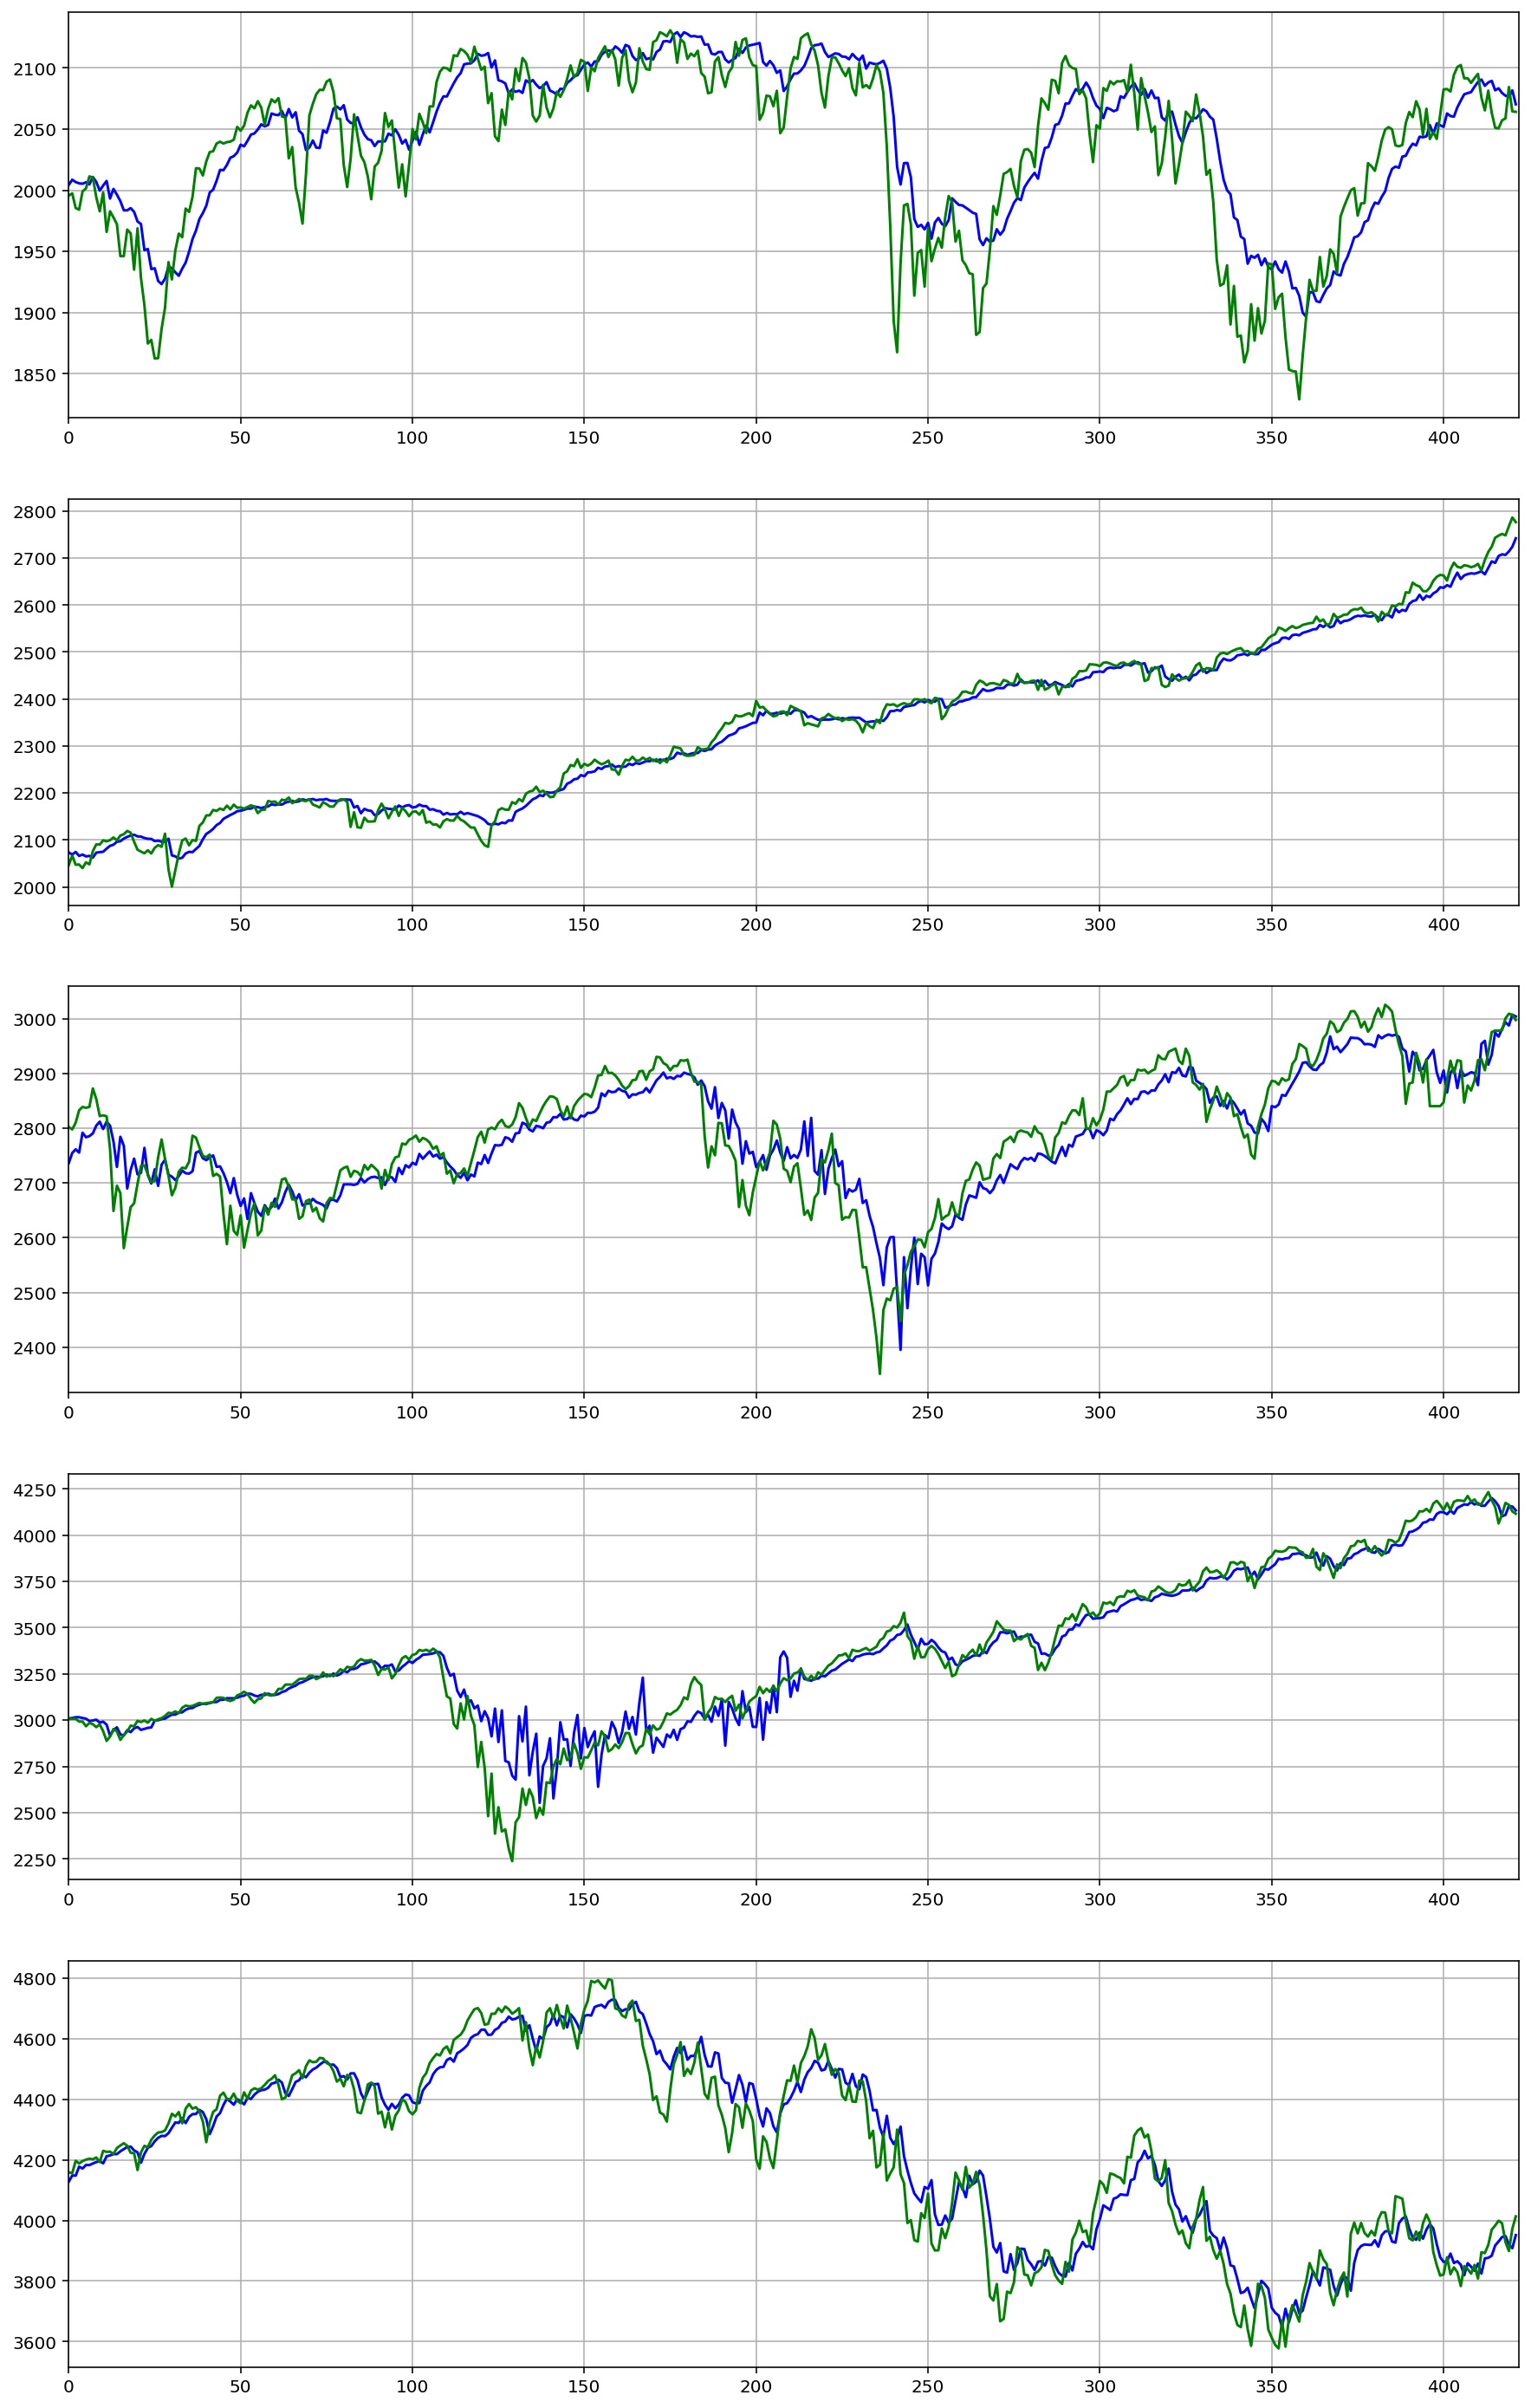

In [383]:
# Create 1 subplot for every "2" years
fig, ax = plt.subplots(5, figsize = (15,25))

for i in range(5):
    ax[i].plot(y_pred_on_test[i * 422: (i + 1) * 422], label = "y_pred_of_test", c = "blue")
    ax[i].plot(y_test[i * 422: (i + 1) * 422], label = "y_test", c = "g")
    ax[i].grid(True)
    ax[i].set_xlim([0,422])

# Using the same strategy to test the outcome